In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Python私房手册-Python那些事

## 基础概念

### 到底什么是可哈希

之前看书总是看到一句话就是不可变对象是可哈希的，可变对象是不可哈希的。总是不明白这个哈希到底是个什么东西，其实说白了，哈希值是人为定义的，如果一个对象有`__hash__`方法，这个方法能返回一个整数值，则这个对象就是可哈希的，如果没有这个方法，就是不可哈希的。一般都是根据专门的哈希算法算出来的。

为什么所有对象需要有这样一个方法呢，需要能返回这样一个哈希值呢，其实是为了在字典和集合这样使用散列表存储数据的结构中查找数据，因为散列表查找值是根据`key`的哈希值来查找的，具体的实现细节查看《字典到底是有序还是无序》一节。简单来说，以字典为例，会先根据要查找的`key`的哈希值的其中几位计算出一个偏置，然后根据这个偏置找到散列表中的一个表元，如果表元为空，则抛出`KeyError`，如果不为空，会查看表元里面存储的`key`和要查找的`key`是不是一致，一致则返回`value`，如果不同，则发生了散列冲突，则会再从要查找的`key`的哈希值重新再取几位计算偏置，再重复以上过程。

In [8]:
class C:
    def __eq__(self, value):
        if hash(self) == hash(value):
            return True

    def __hash__(self):
        return 123456


c1 = C()
c1.name = "c1"
c2 = C()
c2.name = "c2"

c1 == c2  
c1 is c2  # is是根据id来判断的，所以c1 is not c2

True

False

In [7]:
d = {c1: 42}

d[c1]
d[c2]

42

42

如上的例子，即使`c1`和`c2`是两个不同的实例，但是由于他们的哈希值是相同的，而且相等（通过定义`__eq__`方法实现）。所以可以通过`c2`来查找`c1`。        

所以，一个不可变对象，实现了`__eq__`方法，同时需要实现`__hash__`方法，才能作为字典的键，并且要保证在`a == b`为真的情况下`hash(a) == hash(b)`也为真，这样才能实现根据相同的值，来对字典进行读取。

In [57]:
t1 = tuple((1, 2))
t2 = tuple((1, 2))

d = {t1: "t1"}
d
d[t2]

{(1, 2): 't1'}

't1'

而一个可变对象，不是说不能实现`__hash__`方法，而是没法实现哈希值也相同的时候，值一定相同，这就破坏了现有的查找的原则：

In [6]:
from collections import UserList


class MyList(UserList):
    def __hash__(self):
        return id(self)


mylist1 = MyList([1, 2, 3])
d = {mylist1: "I am mylist"}
d

{[1, 2, 3]: 'I am mylist'}

In [7]:
import traceback

mylist2 = MyList([1, 2, 3])
try:
    d[mylist2]
except KeyError:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-7-495c04a71169>", line 5, in <module>
    d[mylist2]
KeyError: [1, 2, 3]


## 基本数据类型

### 字符串

#### unicode原理

- [字符编码笔记：ASCII，Unicode 和 UTF-8](http://www.ruanyifeng.com/blog/2007/10/ascii_unicode_and_utf-8.html)
- [刨根究底字符编码系列](https://blog.csdn.net/liangtaox8/article/list/3)
- [unicode之痛](https://pycoders-weekly-chinese.readthedocs.io/en/latest/issue5/unipain.html#python-3)

之前一直对各种编码转换搞不清楚，`encode`和`decode`老是弄混，突然有一天就想明白了：可以把显示的各种字符，也就是你看到的文字，字母想象成一副图画。而计算机只能存储一些二进制的数字，所以在计算机里面保存了一张巨大的字典，其中键是数字，值就是这些图画。这些数字就是所谓的unicode编码，打印字符其实就是在这个巨大的字典表里面根据数字找到这些图画，然后显示出来。

`unicode`中最大的数字，如果用二进制来表示的话，需要32位bit才行，如果直接在电脑里面保存这些数字，每一个字符就需要使用32bit4个字节。你可能会想，为什么每个字符都使用32bit呢，就用每个数字的二进制来表示不好吗？但是这样的话，如果是连续的多个字符，计算机无法知道如何区分字符。如果都用32bit表示一个字符，就可以每32bit一读。很明显，这样的话会非常的占空间，因此又发明了`utf8`,`utf16`,`utf32`各种编码。可以用比较少的bit数来代表一个字符，主要目的就是为了节省存储空间。

其中`utf8`是变长的，2,3,4字节不等，`utf16`也是变长，但是只能2个或者4个字节，小于65535的用2个字节，大于的用4个字节。而`utf32`完全等同于`unicode`数字。至此，显示一个字符的流程变为，以`utf8`为例，先根据一个字符的`utf8`编码找到对应的`unicode`编码，也就是字典表里的键，然后根据键找到对应的字符，然后再显示出来。

几个知识点：
1. 类似`utf8`,`utf16`，python中`unicode`编码使用`unicode_escape`表示。
2. `\u`开头的字符串是用`unicode`编码数字表示的字符，其编码数字小于65535，一共4位，2个字节，大于65536用`\U`开头的字符串表示，一共8位，4个字节，不足8位前面补0。
3. 以下方法可以帮助记忆什么时候使用`encode`，什么时候使用`decode`：前面带b，表示已经是这个字符的编码，要转换成字符，也就是知道了键的数字，要获取图案，所以要使用`decode`解码。不带b，表示知道了图像，要获取键的数字，因此要编码，使用`encode`。

举个例子：

In [4]:
print('\U0001F48B')

💋


In [5]:
'💋'.encode('unicode_escape')

b'\\U0001f48b'

In [7]:
b'\\U0001f48b'.decode('unicode_escape')

'💋'

In [6]:
'💋'.encode('utf8')

b'\xf0\x9f\x92\x8b'

In [8]:
b'\xf0\x9f\x92\x8b'.decode('utf8')

'💋'

#### 混乱的windows编码

这个问题起因是当在`cmd`中输入`python`，进入python命令行时，出现报错：
```
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] :: Anaconda, Inc. on win32
Type "help", "copyright", "credits" or "license" for more information.
Failed calling sys.__interactivehook__
Traceback (most recent call last):
  File "D:\programs\Anaconda3\lib\site.py", line 439, in register_readline
    readline.read_history_file(history)
  File "D:\programs\Anaconda3\lib\site-packages\pyreadline\rlmain.py", line 165, in read_history_file
    self.mode._history.read_history_file(filename)
  File "D:\programs\Anaconda3\lib\site-packages\pyreadline\lineeditor\history.py", line 83, in read_history_file
    for line in open(filename, 'r'):
UnicodeDecodeError: 'gbk' codec can't decode byte 0x80 in position 2273: illegal multibyte sequence
```
很明显是编码错误，我打印了history.py文件第83行中的filename，提示是`C:\Users\18907\.python_history`的文件，这个文件保存了之前使用`python`命令行输入过的一些历史命令，查看文件的编码是`utf8`格式，说明`cmd`中`open`一个文件使用的是`gbk`编码，解决方案很简单，修改`for line in open(filename, 'r')`，加上`encoding='utf8'`，或者将`.python_hisotry`文件用记事本打开，改为`ANSI`格式，再或者删除这个文件。

不过联想到之前看《流畅的python》一书中的内容，正好对windows下的编码做个总结，直接运行《流畅的python》一书4.5节的例子，如下：

In [1]:
import sys, locale
expressions = """
locale.getpreferredencoding()
type(my_file)
my_file.encoding
sys.stdout.isatty()
sys.stdout.encoding
sys.stdin.isatty()
sys.stdin.encoding
sys.stderr.isatty()
sys.stderr.encoding
sys.getdefaultencoding()
sys.getfilesystemencoding()
"""
my_file = open('dummy', 'w')
for expression in expressions.split():
    value = eval(expression)
    print(expression.rjust(30), '->', repr(value))

 locale.getpreferredencoding() -> 'cp936'
                 type(my_file) -> <class '_io.TextIOWrapper'>
              my_file.encoding -> 'cp936'
           sys.stdout.isatty() -> False
           sys.stdout.encoding -> 'UTF-8'
            sys.stdin.isatty() -> False
            sys.stdin.encoding -> 'cp936'
           sys.stderr.isatty() -> False
           sys.stderr.encoding -> 'UTF-8'
      sys.getdefaultencoding() -> 'utf-8'
   sys.getfilesystemencoding() -> 'utf-8'


上面涉及到的一共有4个编码：
1. 如果打开文件时没有指定 encoding 参数， 默认值由`locale.getpreferredencoding()`提供。
2. 如果设定了PYTHONIOENCODING环境变量，`sys.stdout/stdin/stderr`的编码使用设定的值；否则，继承自所在的控制台；如果输入/输出重定向到文件， 则由`locale.getpreferredencoding()`定义。
3. Python 在二进制数据和字符串之间转换时， 内部使用`sys.getdefaultencoding()`获得的编码；Python 3很少如此，但仍有发生。这个设置不能修改。
4. `sys.getfilesystemencoding()`用于编解码文件名（不是文件内容）。把字符串参数作为文件名传给 open() 函数时就会使用它；如果传入的文件名参数是字节序列， 那就不经改动直接传给 OS API。

综上，`locale.getpreferredencoding()`返回的编码是最重要的：这是打开文件的默认编码，也是重定向到文件的`sys.stdout/stdin/stderr`的默认编码。附：windows10，可以在控制面版-时钟与区域-管理-更改系统区域设置，在Beta版：使用Unicode UTF-8提供全球语言支持前面打勾，这样整个系统都会使用utf8编码。不过老旧的软件可能会出现乱码问题。

### 字典

#### 根据字典的值查找字典的键

In [90]:
dic = {'a': '001', 'b': '002', 'c': '001'}
list(dic.keys())[list(dic.values()).index("001")]

'a'

#### 字典的键是集合

字典的键是集合，因此可以进行各种集合相关的操作（并集、差集）等等：

In [4]:
a = {'x': 1, 'y': 2, 'z': 3}
b = {'w': 10, 'x': 11, 'y': 2}
a.keys() - b.keys()  # 字典的键可以视为集合进行操作

{'z'}

#### 字典作为迭代器参数

一些接收迭代器参数的函数，可以直接传入字典，此时是对字典的键进行迭代：

In [2]:
d = {"a": 1, "b": 2}


def func(data):
    for i in data:
        print(i)


func(d)

a
b


#### 创建字典的副本

`dict`不仅可以接收关键字参数创建一个字典，还可以接收一个字典对象，此时创建一个字典对象的副本：

In [45]:
d1 = {"a": 1}
d2 = dict(d1)
id(d1)
id(d2)

1733179455240

1733178158968

#### 字典到底是有序还是无序

[stackoverflow关于此问题的讨论](https://stackoverflow.com/questions/39980323/are-dictionaries-ordered-in-python-3-6?r=SearchResults)

要弄清楚字典是有序还是无序，需要理解字典的底层存储原理。之前讨论过什么是可哈希，在3.6版本以前，字典其实是以散列表的形式进行存储。散列表是一个稀疏数组，里面是一个个固定大小的表元，表元里存储着字典的键和值的引用，就像下面这样（第一个数字保存的应该是加盐以后的`key`的哈希值，查找的时候key和哈希值都要比较，图只是方便理解，存储的其实是引用）：
```
d = {'timmy': 'red', 'barry': 'green', 'guido': 'blue'}

entries = [['--', '--', '--'],
           [-8522787127447073495, 'barry', 'green'],
           ['--', '--', '--'],
           ['--', '--', '--'],
           ['--', '--', '--'],
           [-9092791511155847987, 'timmy', 'red'],
           ['--', '--', '--'],
           [-6480567542315338377, 'guido', 'blue']]
```
当查找字典时，比如查找`d['timmy']`时，会先计算`timmy`的哈希值，假设计算出来是5，然后根据哈希值的最后几位数字（具体是几位，根据字典的大小来决定）计算一个偏置，由于表元大小是固定的，根据偏置就可以很快的计算出`barry`所在的表元的位置。可见，存储的位置其实是和哈希值也叫散列值有关，因此在3.6以前，字典其实是无序的，这里说的无序只是不是按照插入顺序保存，其实在内部的位置是固定的，都是按照哈希值计算出来的位置进行保存。

3.6版本以后，内部存储结构变了，现在是像下面这样进行存储：
```
indices =  [None, 1, None, None, None, 0, None, 2]
entries =  [[-9092791511155847987, 'timmy', 'red'],
            [-8522787127447073495, 'barry', 'green'],
            [-6480567542315338377, 'guido', 'blue']]
```
`entries`总是按照插入顺序保存字典的元素，然后多了一个`indices`的列表，保存着`entries`数组的索引。现在再查找`d['timmy']`时，比如根据哈希值计算出是5，会先在`indices`中找到第5个元素为0，说明`d['timmy']`在`entries`的位置0（`indices`应该也是表元大小固定的散列表，这样才能做到快速查找）。可见，新的数据结构大大减少了字典的内存占用，而且保留了字典的插入顺序。

但是由于`indices`也是根据哈希值计算偏置来查找索引，因此感觉仍然不能避免散列冲突，同时`indices`数组应该也需要动态扩容。所以还是不要在迭代字典的同时对字典进行修改。

进一步的细节参考《流畅的python》第三章。

### 列表

#### 从后往前轮询

切片第三个参数-1即表示从后往前轮询：

In [45]:
a = 'abcdefg'
print(a[:3:-1])  #-1表示从后往前

gfe


#### 如何在循环的时候修改列表

如果仅仅只是修改某个元素，是没有问题的，如下的代码：

In [5]:
alist = [1, 2, 3, 4, 5]
for i in alist:
    if i == 3:
        alist[2] = "bingo"

print(alist)

[1, 2, 'bingo', 4, 5]


但如果要删除或者插入一个元素，就容易出问题，如下，本来想要当i为3的时候删除，不为3的时候打印，结果只打印了1、2、5，少打印了4，是因为`for`循环列表是调用列表的`__getitem__`方法，根据下标返回元素，因此删除以后后面的元素会前移，因此会跳过一个元素：

In [12]:
alist = [1, 2, 3, 4, 5]
for i in alist:
    if i == 3:
        alist.remove(i)
    else:
        print(i)

print(alist)

1
2
5
[1, 2, 4, 5]


可以用`iter`函数包装一下，或者直接使用`alist[:]`返回一个列表的副本，这样，修改原列表就不会再影响到返回的副本，注意：迭代器是调用对象的`__next__`方法而不是`__getitem__`。

In [13]:
for i in iter(alist):
    if i == 3:
        alist.remove(i)
    else:
        print(i)

1
2
4
5


### 其它的数据结构

除了常用的`dict`,`list`，`set`，`python`还有很多其它的数据结构，可能由于前面几个太好用了，其它的使用得就没那么多，甚至知道的人都不多，这里对所有内置的数据结构进行一个梳理，并尝试给出使用场景。

#### `collections.ChainMap`

#### `queue`模块

`queue`模块下主要包含三种队列数据结构，分别是普通先进先出的`Queue`，后进先出的`LiFoQueue`和一个优先级队列`PriorityQueue`，另外还有一个无界的`SimpleQueue`，也是先进先出队伍，但是缺少任务跟踪等高级功能。这些队列都是线程安全的，所以多线程需要使用共享数据时，优先选择使用这几个队列。  

这里主要记录如何在多线程中使用队列，先介绍几个`queue`的主要方法和属性：
- `put(item, block=True, timeout=None)`：向队列放入一个任务，如果`block`为`True`，意思是阻塞`put`所在的当前线程，等着队列空出槽位，如果`timeout`为None，就会一直等下去。如果设置了值，那么在等待时间到达以后，队列还没有空出槽位，则抛出`full`的错误。如果`block`为`False`，那么就不会等待，立即向队列插入，如果队列是满的，直接抛出`full`错误。这个时候`timeout`参数就失效了。
- `put_nowait(item)`：就相当于`block`为`False`。
- `get(block=True, timeout=None)`：和`put`正好相反，一个是放，一个是取，同时抛出的是`empty`错误。
- `get_nowait()`：相当于`get`中的`block`为`False`。
- `task_done()`：当线程`get`一个任务，并且这个任务执行完了，需要调用队列的`task_done`方法，通知队列任务已经执行完毕，此时队列才会释放空的槽位。所以，这个方法调用和任务应该是一对一的关系，如果调用次数大于任务的数量，会抛出`ValueError`的错误。
- `join()`：阻塞主线程，一直到队列里的所有任务都执行完毕。

具体看例子：

In [ ]:
from queue import Queue
from threading import Thread
from time import sleep

# 定义一个存放任务的队列
q = Queue()


def do_job(name, job_number):
    print(f"{name} start do his job {job_number}")
    sleep(job_number)
    print(f"{name} finish his job {job_number}")


# 定义一个在线程里面执行的函数
def worker():
    # 循环获取任务
    while True:
        # 从队列里面获取任务，因为block为True，如果此时队列为空，线程会阻塞，等待队列里面有任务
        task = q.get(block=True)
        # 当收到的任务是None的时候，跳出循环
        if task is None:
            print("thread end")
            break
        worker_name, job_number = task
        # 这里相当于定义实际要做的工作
        do_job(worker_name, job_number)
        # 完成以后要调用队列的task_done()方法，通知队列任务已经完成
        q.task_done()


ts = []  # 创建一个线程的空列表

# 创建3个线程，并启动，启动完了会马上回到主线程，将线程添加到列表
for i in range(6):
    t = Thread(target=worker)
    # 启动线程，因为任务队列现在是空的，所以线程会在q.get处阻塞，等待队列里有任务
    t.start()
    ts.append(t)

# 所有的任务
tasks = [("Tom", 3), ("John", 2), ("Tom", 2), ("John", 1), ("Tom", 1), ("John", 3)]

# 将任务put进队列，此时阻塞的线程会开始接收到任务，向下执行
for t in tasks:
    q.put(t)

# 队列需要join，等待所有任务执行完毕
q.join()

# 所有任务执行完毕，此时队列又为空，所有线程又会阻塞在q.get()，所以需要向队列put与任务相同数量的None，以便线程结束
for i in range(len(tasks)):
    q.put(None)

# 默认会等待所有线程结束，也可以手动阻塞，等待线程结束
for t in ts:
    t.join()

Tom start do his job 3
John start do his job 2
Tom start do his job 2
John start do his job 1
Tom start do his job 1
John start do his job 3
John finish his job 1
Tom finish his job 1
John finish his job 2
Tom finish his job 2
Tom finish his job 3
John finish his job 3


注意，`task_done`和`join`主要是为了同步，不加也可以正常执行。

其它的`Queue`的用法类似，这里提一下优先级队列，优先级队列需要传入一个可以进行比较的对象，

## 基本语法

### 括号里的不同行字符串

括号里的字符串可以不在一行上，`python`默认会将其合并，注意中间不能加逗号：

In [117]:
text1 = ('a' 
         'b')
text2 = 'ab'
type(text1)
text1 == text2
print(text1)

str

True

ab


### 关于`exec`

`exec()`可以执行字符串形式的语句，但是要注意的是它在局部范围中的行为，主要有两点：
1. 在局部范围内，总是收集所有的局部变量，组成一个字典传递给`exec`，也就是说传递给`exec`的并不是实际的局部变量，而是一个副本。
2. 每次运行`locals()`方法，就相当于重新收集一次所有的局部变量。

In [3]:
def func():
    a = 12
    exec("b = a + 2")
    print(b)

func()

NameError: name 'b' is not defined

如上，在函数范围内，其实并没有`b`变量。可以这样做：

In [4]:
def func():
    a = 12
    loc = locals()
    exec("b = a + 2")
    b = loc['b']
    print(b)

func()

14


注意，`locals()`返回的也是局部范围内所有变量构成的字典的副本，和传入`exec`的是同一个，并不会运行`locals()`的时候产生一个副本，执行`exec`的时候又产生一个副本。同时要注意，每次运行`locals()`方法，会收集当前的所有局部变量更新这个副本（始终只有一个副本）：

In [8]:
def func():
    a = 12
    loc = locals()
    print(loc)
    exec("a += 2")
    print(loc)
    locals()
    print(loc)

func()

{'a': 12}
{'a': 14, 'loc': {...}}
{'a': 12, 'loc': {...}}


如果这样的行为让你疑惑，可以使用`exec`的后两个参数明确的传递表示作用域的字典给它，`exec`只会操作这个字典里的变量，不会影响到实际的变量：

In [12]:
def func():
    a = 12
    loc = {"a": a}
    exec("a += 2", {}, loc)
    print(loc['a'])
    print(a)
    
func()

14
12


## 运算符

[《Python运算符速查手册》](http://www.runoob.com/python/python-operators.html)

### 利用&判断奇偶

`&`是位运算符，指按位与，奇数二进制最后一位为1，与1按位与以后最低位为1，其它位为0，因此奇数为1（`True`），偶数为0（`False`）：

In [109]:
def fun(x):
    return True if x & 1 else False

5 & 1
4 & 1
sum(filter(fun, range(5)))

1

0

4

## 内置函数

### `round()`

第2个参数表示精度，如下的例子，-1表示四舍五入到10位：

In [110]:
round(11, -1)
round(16, -1)

10

20

### `eval() exec() global() locals()`以及`compile()`

- [Python中的eval()、exec()及其相关函数](https://www.cnblogs.com/yyds/p/6276746.html)
- [What's the difference between eval, exec, and compile?](https://stackoverflow.com/questions/2220699/whats-the-difference-between-eval-exec-and-compile/29456463#29456463)

`eval()`和`exec()`可以将字符串当作代码来执行，相当于可以动态的产生并执行代码，`eval`一般执行简单的表达式，并且有返回值，`exec`可以执行复杂的语句，但是返回值永远是`None`，第二个参数、第三个参数分别用来指定全局作用域和局部作用域，它们的最大区别实际上来自于`compile`及其模式:
1. 可以先将字符串`compile()`成字节码，然后再`eval()`或者`exec()`,这可以加速对相同代码的反复调用。`compile`第三个参数接收`exec`,`eval`和`single`三种模式，返回一个`code`对象。实际上，如果将包含源代码的`str/unicode/bytes`传递给`eval`或者`exec`，它的行为相当于`eval(compile(source, '<string>', 'eval'))`或者`exec(compile(source, '<string>', 'exec'))`。
2. 可以先`compile(source, '<string>', 'exec')`,将返回的`code`对象传递给`eval`，这样使用`eval`也可以执行语句，不过返回的值为`None`，此时`eval`和`exec`没有区别。

### 使用`sys.stdin`进行交互

平时我们与用户交互，大部分时候都是使用`input`函数，但是`input`只能接收单行。如果想接收多行的话呢？此时我们可以使用`sys.stdin.read()`，`sys.stdin.readlines()`,`sys.stdin.readline()`方法。但是有个小问题，多行输入的时候如何才能结束呢？

这里涉及到一个系统方面的知识，只有输入`EOF`（end of file)文件结束符，系统才认为你的输入已经结束。对于windows来说，`EOF`是`CTRL+Z`的组合，对于Linux，`EOF`是`CTRL+D`的组合。

这里有几点要注意：
1. 对于windows系统，每当我们输入一行按回车的时候，系统会把这一行数据先送到一个缓存存储起来。当在一行的中间或者末尾按下`CTRL+Z`，系统不会认为这是一个`EOF`，而是把它当作一个普通的字符。当在一行的行首按下`CTRL+Z`，系统就会认为这是一个`EOF`，然后把缓存中的数据全部输出到程序。研究以下代码：
```
>>> r = sys.stdin.read()
the sky is ^Z blue,
the sea is blue^Z,
^Z
>>> r
'the sky is \x1a blue,\nthe sea is blue\x1a,\n'
```
可见，`CTRL+Z`在行首才能结束输入，否则系统只是把它当作`\xla`的字符。
2. linux目前还未测试，但是它与windows不同，待以后测试后补上。

## 时间和日期

`python`中时间和日期不难，但是常常写代码的时候，却有不知从何下手的感觉，特别是内置有`time`和`datetime`两个库，不知道用那个。这里在别人的基础上添加一点自己的理解，先看[Python时间日期格式化之time与datetime模块总结](https://www.cnblogs.com/chenhuabin/p/10099766.html)。

`time`在官方文档中,被分类在通用操作系统服务中，`datetime`是对`time`的封装，分类在数据类型中，从分类就可以看出,`time`倾向于提供开发中与系统时间相关的功能，它还包含诸如 返回指定的线程id的特定于线程的CPU时间时钟的clk_id 这样的函数，而`datetime`更倾向于用作数据分析和处理。

### `time`模块

在`python`中，所有的时间有三种基本格式，分别是时间戳，时间元组和时间字符串。它们的关系如下：
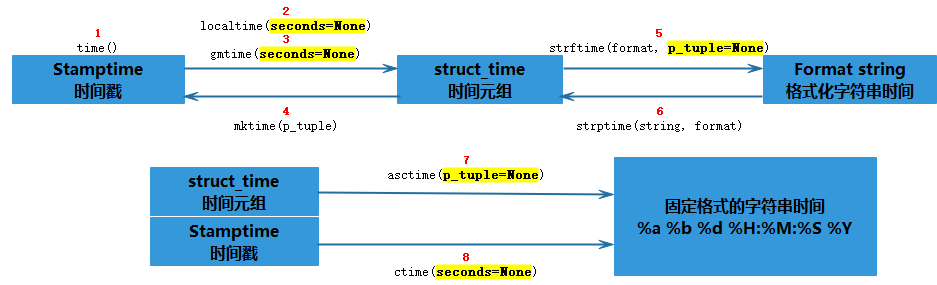

这里记录几个要点：
1. 所有这些函数都是`time`的顶层函数，是没有对象的转换方法的。
2. `localtime`是转换为本地时间，`gmtime`是转换为标准时间。
3. `asctime`和`ctime`相当于两个快捷方法，直接将时间元组和时间戳转换为固定格式的字符串。
4. 格式化参数见[官方文档](https://docs.python.org/zh-cn/3/library/time.html)。

In [35]:
import time

now = time.time()
localtime = time.localtime(now)
gmtime = time.gmtime(now)
localtime
gmtime
time.strftime("%Y-%m-%d %H:%M", localtime)
time.ctime(now)
time.asctime(gmtime)

time.struct_time(tm_year=2019, tm_mon=12, tm_mday=12, tm_hour=16, tm_min=12, tm_sec=44, tm_wday=3, tm_yday=346, tm_isdst=0)

time.struct_time(tm_year=2019, tm_mon=12, tm_mday=12, tm_hour=8, tm_min=12, tm_sec=44, tm_wday=3, tm_yday=346, tm_isdst=0)

'2019-12-12 16:12'

'Thu Dec 12 16:12:44 2019'

'Thu Dec 12 08:12:44 2019'

### `datetime`模块

`datetime`模块有`date`，`time`，`datetime`，`timedelta`和`tzinfo`五个类，分别提供对日期、时间、时间日期、时间间隔、时区的处理。

#### `datetime.date`和`datetime.time`

`date`和`time`本质上是时间元组，由于只包含部分时间信息，除了直接通过参数构造对象以外，`date`只提供了将时间戳转换为`date`对象，以及转换成字符串的方法，而`time`只提供转换成字符串的方法，均不能反向转换，即将字符串转换成`date`或者`time`对象，也不能将`date`或者`time`对象还原成时间戳。

In [43]:
from datetime import date

# 通过today函数
d1 = date.today()
# 通过参数构造
d2 = date(year=2019, month=12, day=12)
# 通过时间戳构造
d3 = date.fromtimestamp(now)
d1
d2
d3
d1.strftime()

datetime.date(2019, 12, 12)

datetime.date(2019, 12, 12)

datetime.date(2019, 12, 12)

#### `datetime.datetime`

`datetime`类结合了`date`和`time`两个类，因为它具备了所有的时间信息，因此它可以在各种不同的时间格式中自由转换：

In [64]:
from datetime import datetime

In [69]:
now = datetime.now()
today = datetime.today()
now
today

datetime.datetime(2019, 12, 12, 17, 42, 36, 795643)

datetime.datetime(2019, 12, 12, 17, 42, 36, 795644)

In [84]:
datetime.fromtimestamp(time.time())
datetime.strptime("2019-12-12 23:59:59", "%Y-%m-%d %H:%M:%S")
# 同样有ctime方法，注意和time.ctime方法不同，datetime.ctime的参数是datetime对象而不是时间戳
datetime.ctime(now)

datetime.datetime(2019, 12, 12, 17, 51, 11, 221928)

datetime.datetime(2019, 12, 12, 23, 59, 59)

'Thu Dec 12 17:42:36 2019'

可以分别获取日期和时间，再用`combine`同时可以将日期和时间合并：

In [73]:
d = now.date()
t = now.time()
datetime.combine(d, t)

datetime.datetime(2019, 12, 12, 17, 42, 36, 795643)

#### `datetime.timetelta`

`timedelta`主要是用来进行时间之间的运算，比如：

In [2]:
from datetime import datetime, timedelta
import time

now = datetime.now() 
three_hours_ago = now - timedelta(hours=3)
now
three_hours_ago

#### 时区转换

`datetime`模块可以把utc格式的时间转换成本地时间，但是不太好用。先来看个概念，`python`的`datetime`对象和`time`对象分为感知型和简单型两种，简单来说，不带时区信息的是简单型，带了时区信息的是感知型，准确的判断条件是，对象同时满足以下两个条件则为感知型：
1. `d.tzinfo` 不为 `None`
2. `d.tzinfo.utcoffset(d)` 不返回 `None`

先看以下一段代码，使用`astimezone`方法将`utc`标准时间转换成本地时间：

In [5]:
from datetime import datetime, timezone

now = datetime.now()
now_utc = now.replace(tzinfo=timezone.utc)
local = now_utc.astimezone()

print(now)
print(now_utc)
print(local)

2020-03-25 11:14:09.708928
2020-03-25 11:14:09.708928+00:00
2020-03-25 19:14:09.708928+08:00


如果不了解感知型和简单型两种时间类型，会觉得转换方法很别扭。因为平时我们通过`datetime`的`now`函数虽然获取的是本机的时间（也就是本地的当前时间），但是是简单型，不带时区信息。当使用`replace`方法加入时区信息的时候，变成了感知型，但是注意，此时只是简单加了时区信息，并未发生时区的转换。再使用`astimezone`函数将`utc`时间转换成本地时间。

如果要在时区之间转换，最简单的方法是使用`pytz`库（《编写高质量python的59个方法》中说要执行时区偏移的操作，需要先转成`utc`格式的`datetime`对象，但是自己测试仅仅只是时区转换的话，貌似可以直接转换）：

In [97]:
import pytz

now = datetime.now()
tz_sh = pytz.timezone('Asia/Shanghai')
sh_dt = tz_sh.localize(now)
tz_eastern = pytz.timezone('US/Eastern')
eastern_dt = tz_eastern.normalize(sh_dt)
print(sh_dt)
print(eastern_dt)

2020-01-10 11:40:53.035046+08:00
2020-01-09 22:40:53.035046-05:00


### 时间格式

常用的时间格式符如下：
- [时间格式符查询](https://www.cnblogs.com/fwl8888/p/9635505.html)

## 文件与路径

### 文件的`writelines()`方法

`f.write`的参数是`str`，`f.writelines`的参数是可迭代对象

In [4]:
s = ['1','2','3']
with open('s.txt','w') as f:
    f.writelines(s)

### `os.path.abspath`和`os.path.realpath`的区别

主要在`Linux`系统上，这两个命令有区别，`abspath`返回文件的绝对目录，不管是实际的文件还是软链接，`realpath`总是返回文件真实的绝对目录。

## 正则表达式

### 易错概念

#### `search`、`findall`，`finditer`和的区别

刚开始的时候对于什么时候用哪个方法总是弄不太清楚，所以这里做个梳理，并且总结重难点：
1. `findall`和`finditer`是全局匹配，简单说如果文本中有2个及以上能匹配上正则，则都会找出来。而`search`只会返回第一个匹配成功的结果。
2. 如果正则表达式不包含分组，则`findall`返回所有匹配成功的结果构成的列表，如果包含分组，则返回的列表只包含所有匹配成功的分组构成的元组，而不会包含匹配成功的完整结果。
3. `finditer`弥补了有分组时，无法返回完整结果的缺点。它是一个生成器，每次返回一个匹配成功的`match`对象，和`search`返回的结果一样。因此可以根据需求提取想要的结果。

In [37]:
text = "This is a test string, That has two test lines"
m = re.search(r"(Th\w+).*?(test)", text)  # 注意是非贪婪匹配
# search方法只能匹配第一句，匹配成功就返回了。
m.groups()
m.group(0)
# 正则里面不包含分组，则返回完整的匹配成功的结果
re.findall(r"Th\w+.*?test", text)
# 正则里面包含分组，则列表只返回匹配成功的分组构成的元组
re.findall(r"(Th\w+).*?(test)", text)
# 如果正则里面包含分组，又要获取完整的匹配结果，只能用finditer，返回的每一个匹配成功的match对象，通过match对象的group(0)获取完整结果
for m in re.finditer(r"(Th\w+).*?(test)", text):
    print(m.group(0))

('This', 'test')

'This is a test'

['This is a test', 'That has two test']

[('This', 'test'), ('That', 'test')]

This is a test
That has two test


#### 扩展表示法

这里记录正则表达式中常用的扩展表示法：

```python
(?:)              :    不捕获分组
(?#)              :    不做匹配，只是用作注释
(?=)              :    右等于零宽断言
(?!)              :    右不等于零宽断言
(?<=)             :    左等于零宽断言
(?<!)             :    左不等于零宽断言
(?(1)y|x)         :    根据捕获的分组选择，如果捕获的分组1存在，就选y，否则选x
(?P<name>)        :    为分组命名
 ```

#### 嵌套的括号分组

如果分组是嵌套的，则先从外向内数，数字依次增加，然后从左往右数，数字依次增加，如：

In [70]:
import re

text = "This is a test string"
m = re.search(r"(T\w+(is)).*(s(tr)\w+)", text)
m.groups()

('This', 'is', 'string', 'tr')

#### 命名分组以及如何引用分组

可以对分组命名，主要注意一下写法，命名分组可以通过`group(name)`调用，同时位置分组仍然可用。另外后续引用有几点要注意：
1. 后续引用前面匹配的结果，可以`(?P=)`这样写，注意此时不会捕获后续引用的分组，如果想要捕获，要在外面再加个括号。
2. 在`sub`方法中如果要引用前面的命名分组，使用`\g<>`的方式，如果是位置分组，使用`\1`,`\2`的形式引用。

In [60]:
import re

text = "This is a test string\nThis has two lines"
m = re.search(r"(?P<a>t\w+s).*((?P=a)).*", text,
              re.I + re.S)  # 要捕获引用的分组，要再加个括号
m.group("a")
m.group(1)  # 位置分组和命名分组均可用
m.groups()

'This'

'This'

('This', 'This')

注意，此时`r"(?P<a>t\w+s).*"`匹配上整个句子，用`"\g<a> is over"`替换掉整个句子，且使用`\g<a>`保留了之前匹配上的命名分组。此时位置分组用`\1,\2`来表示：

In [67]:
re.sub(r"(?P<a>t\w+s).*", r"\g<a> is over", text, flags=re.I + re.S)

'This is over'

#### 零宽断言

所谓零宽，指的是匹配的是位置，而不是字符，宽度为0，因此叫零宽。网上或者一些书里面都称作向前（向后）正向（负向）零宽断言，感觉很不好理解，不如叫做左边（右边）等于（不等于）零宽断言好记。一般的形式有4种：
- `(?=条件)`  这个位置的右边等于条件。
- `(?!条件)`  这个位置的右边不等于条件。
- `(?<=条件)` 这个位置的左边等于条件。
- `(?<!条件)` 这个位置的左边不等于条件。

如下的例子，仔细分辨其中的细微差别：

In [9]:
import re

text = "port up up states"
# 括号里面匹配一个位置和一个任意字符，表示任意字符前面的位置后面都不能是up\s+up，因此匹配不上，返回None
re.search(r"^((?!up\s+up).)*$", text)
re.search(r"((?!up\s+up).)*$", text)
re.search(r"^((?!up\s+up).)*", text)
re.search(r"^(?!up\s+up).*", text)

<re.Match object; span=(6, 17), match='p up states'>

<re.Match object; span=(0, 5), match='port '>

<re.Match object; span=(0, 17), match='port up up states'>

#### `groups`，`group`的区别

正则匹配以后，如果没有匹配上，返回`None`，如果匹配上，返回一个`match`对象。`match`对象有`groups`和`group`方法，区别如下：
1. `groups`返回捕获的分组构成的元组，如果没有分组，则返回一个空的元组。
2. `group`指单独的捕获的分组，其中`group(0)`和`group()`均指匹配上的整个字符串，注意，捕获的分组从1开始计数。

In [20]:
import re

text = "This is a test string\nText has two lines"
m = re.search(r"(t\w+s).*(t\w+t).*", text, re.I + re.S)
m.groups()
m.group()
m.group(0)
m.group(1)
m.group(2)

('This', 'Text')

'This is a test string\nText has two lines'

'This is a test string\nText has two lines'

'This'

'Text'

#### 贪婪匹配和非贪婪匹配

默认情况下是贪婪匹配，还是上面的例子，`.`会尽可能多的匹配符合条件的字符，因此第二个分组匹配到的是"Text"，如果在匹配模式`(*,+,?,{m,n})`后面加上`?`，则开启非贪婪模式，表示尽可能少的匹配，如下面的例子，因此，第二个分组匹配到的是`test`：

In [22]:
import re

text = "This is a test string\nText has two lines"
m = re.search(r"(t\w+s).*?(t\w+t).*", text, re.I + re.S)
m.groups()

('This', 'test')

### `re`标识符

#### 同时添加多个标识

如果要同时添加多个标识（`flag`），使用`+`号：

In [18]:
import re

text = "This is a test string\nText has two lines"
re.search(r"t.*t", text, re.I + re.S)

<re.Match object; span=(0, 32), match='This is a test string\nText has t'>

#### `re.S`标识符（同`re.DOTALL`）

`re.S`表示单行匹配，`.`的作用扩展到整个字符串，包括`“\n”`，默认情况下只匹配一行。

In [1]:
import re

text='123\n\tabc'
result1 = re.findall('.+', text, re.S) #re.S表示.的作用扩展到整个字符串，包括“\n”。
result2 = re.findall('.+', text, re.DOTALL) #re.DOTALL作用与re.S一样
result1 == result2

True

#### `re.X`标识符（同`re.VERBOSE`）

`re.X`表示多行匹配，可以把正则表达式的`pat`写成多行，并且自动忽略空格，主要是方便对复杂的正则表达式写注释：

In [4]:
text = '12345abcd'
re.findall('345 abc', text, re.VERBOSE) #re.VERBOSE可以把正则表达式写成多行，并且自动忽略空格

['345abc']

In [23]:
text = '12345abcd'
pat = re.compile("""
345 #方便对复杂的正则表达式进行注释
ab  #re.X和re.VERBOSE是一样的
""", re.X)
pat.findall(text)

['345ab']

### `re`方法

#### `re.subn()`

`subn()`第三个参数代表替换的次数，其返回的一个元组，包含替换后的字符串和替换次数

In [119]:
import re
re.subn('[a-z]','1','abc') 
re.subn('[a-z]','1','abc', 2)

('111', 3)

('11c', 2)

#### `re.escape()`

`escape`可以对字符串中所有可能被解释为正则运算符的字符进行转义

In [96]:
re.escape('hello .python') 
re.findall(re.escape('w.py'),'jw.pyji w.py.f')

'hello\\ \\.python'

['w.py', 'w.py']

## 函数

### 强力辅助`functools`模块

### 什么时候用`nonlocal`

今天写一段代码发生了错误，简化的代码如下：
```python
def func():
    nonlocal var
    print(var)
    
def printvar():
    var = 42
    func()
    
printvar()
```
结果出现了语法错误：`SyntaxError: no binding for nonlocal 'var' found`，提示没有发现`nonlocal var`可以绑定的变量。所以，`nonlocal`只能在嵌套函数中使用，表示该变量属于外层函数，如下：
```python
def func():
    def printvar():
        nonlocal var
        print(var)
    
    var = 42
    printvar() 
    
func()  # 输出42
```
有意思的是，上面的程序如果是脚本，可以正常运行，但如果是命令行模式，同样会抛出`SyntaxError: no binding for nonlocal 'var' found`错误，推测是因为脚本和命令行模式编译的顺序不一样，对于脚本而言，会将函数作为一个整体由外向内的进行编译，即先声明外层函数的所有变量，再逐层声明内部函数体内的变量，从而可以顺利将`var`与外层函数的变量进行绑定，而命令行是逐行编译，当运行到`nonlocal var`语句时，外层函数还没有声明`var`变量，因此会报错。所以，在命令行中，`var = 42`语句需要放在`def printvar()`函数定义的前面。

这里其实并不需要`nonlocal var`语句，如下：
```python
def func():
    def printvar():
        print(var)
    
    var = 42
    printvar()

func()  # 输出42
```
此时，脚本模式和命令行模式都可以顺利运行，因为没有`nonlocal`关键字，命令行模式并不会去检查`printvar`内部的`var`变量与谁绑定，因此不会报错。
在这里，不声明`nonlocal`似乎更好，那么，什么情况下需要使用`nonlocal`声明呢？答案是，当内层函数需要修改外层函数的变量时，必须要使用`nonlocal`声明。如下：

In [4]:
def sort_priority(numbers, group):
    found = False
    def helper(x):
        if x in group:
            found = True
            return (0, x)
        return (1, x)
    numbers.sort(key=helper)
    return found

numbers = [2, 5, 1, 8, 10]
sort_priority(numbers, [6, 7, 8, 9, 10])
print(numbers)

False

[8, 10, 1, 2, 5]


上面的代码是给出一个组，如果`numbers`内的元素在`group`中，则优先排序。返回的`numbers`排序是对的，但是`found`值不对，因为这里返回的其实是外层函数的`found`，内层函数通过赋值，创建了一个属于内层函数的`found`变量。而内层函数的本意是修改外层函数的`found`变量，因此这里必须要使用`nonlocal`声明，如下：

In [5]:
def sort_priority(numbers, group):
    found = False
    def helper(x):
        nonlocal found
        if x in group:
            found = True
            return (0, x)
        return (1, x)
    numbers.sort(key=helper)
    return found

numbers = [2, 5, 1, 8, 10]
sort_priority(numbers, [6, 7, 8, 9, 10])
print(numbers)

True

[8, 10, 1, 2, 5]


最后总结一下：
1. `nonlocal`只能在嵌套函数的内层函数中使用，表明该变量属于外层函数。
2. `nonlocal`主要用来在内层函数中修改外层函数的变量的值，如果仅仅只是引用外层函数的变量而不修改，根据作用域查找规则，可以不使用`nonlocal`。

## 类和对象

### 容易出错的`__getattribute__`

有以下几点要注意：
1. 只有在实例中查找属性的时候才会触发`__getattribute__`，在类中查找则不会触发。所以如果是`C.attr(c)`这样的调用，不会触发。
2. 大多数特殊方法直接在类中查找属性，不会触发，因此编写委托类的时候，这些特殊方法需要重写。但是`dir`比较特殊，从实例中查找，因此会触发。
3. `hasattr`函数也会触发`__getattribute__`。

### 关于`super()`

`super()`一直是觉得比较神奇的一个方法，特别是不带参数的时候，会神奇的自动绑定相应的对象。但是太神奇了，有时候容易出错，而且错误不容易排查。因此做一个梳理。`super()`返回一个带`__get__`方法的描述符对象，主要有2点要注意：
1. `super()`在多继承的时候按照`mro`的顺序调用父类。

In [90]:
class Base:
    def __init__(self):
        print("Base inited.")


class ChildA(Base):
    def __init__(self):
        super().__init__()
        print("ChildA inited")


class ChildB(Base):
    def __init__(self):
        super().__init__()
        print("ChildB inited")


class User(ChildA, ChildB):
    def __init__(self):
        super().__init__()


User.mro()
u = User()

[__main__.User, __main__.ChildA, __main__.ChildB, __main__.Base, object]

Base inited.
ChildB inited
ChildA inited


In [83]:
class Base:
    def __init__(self):
        print("Base inited.")


class ChildA(Base):
    def __init__(self):
        Base.__init__(self)
        print("ChildA inited")


class ChildB(Base):
    def __init__(self):
        Base.__init__(self)
        print("ChildB inited")


class User(ChildA, ChildB):
    def __init__(self):
        super().__init__()


# User的super()返回的是ChildA，ChildA中直接调用Base，因此不会调用ChildB中的__init__方法
u = User()

Base inited.
ChildA inited


2. `super()`总是尽可能的将正确的参数传递给方法，在内部做了很多工作，但是这样有时候反而容易让人疑惑。

In [88]:
class C:
    data = "data"

    def method(*args):
        print(args)

    @classmethod
    def cmethod(*args):
        print(args)

    @staticmethod
    def smethod(*args):
        print(args)


class SubC(C):
    def __init__(self):
        super().method()
        super().cmethod()
        super().smethod()
        print("=" * 50)
        super(SubC, self).method()  # 正确，将self传递给方法
        super(SubC, self).cmethod()  # 正确，虽然调用的是super(SubC, self)，但是传入方法的不是self而是class
        super(SubC, self).smethod()  # 正确，没有参数传递
        print("=" * 50)
        super(SubC, SubC).method()  # 错误，没有参数传递给方法
        super(SubC, SubC).cmethod()  # 正确，将class传递给方法
        super(SubC, SubC).smethod()  # 正确，没有参数传递


sc = SubC()

(<__main__.SubC object at 0x000002516734B240>,)
(<class '__main__.SubC'>,)
()
(<__main__.SubC object at 0x000002516734B240>,)
(<class '__main__.SubC'>,)
()
()
(<class '__main__.SubC'>,)
()


由此可见，`super`并不是简单的将第二个参数传递给方法，而是在内部进行了判断，尽可能的将正确的对象传递给方法，唯一的例外是用`super(type, type2)`方式调用实例方法的时候，由于`super()`不知道要传递给方法的实例是什么，此时会什么都不传。其它情况下，都能传递正确的对象给方法。  

仔细思考如下代码，加深理解：

In [119]:
from inspect import signature


class Base:
    def func(self):
        print(self.x + self.y)


class C(Base):
    def func(self):
        self.x = 2
        self.y = 3
        super(C, self).func()


c = C()
c.func()

5


### `__new__`方法以及在`__new__`方法中使用`super()`的一个bug

`__new__`方法有3点需要注意：
1. `__new__`方法接收的第一个参数是类本身，`__new__`是一个静态方法而不是类方法，所以不存在绑定一说，不会自动传入第一个参数。
2. 当`super()`方法省略参数的时候，`super()`方法会在堆栈中寻找类(`__class__`)以及第一个参数。
>The zero argument form automatically searches the stack frame for the class (__class__) and the first argument.
3. 如果在`__new__`中使用`super()`并且省略参数，必须显示的传入第一个`cls`参数，不能使用动态参数(比如`*args`)，否则会报错（可以视为一个bug）。或者显示的使用`super(type, obj_or_type)`方式进行调用。

In [275]:
class C:
    def __new__(*args):
        print("Create c object.")
        # 注意不能 return super().__new__(*args)，这样会报错
        # 注意，这种形式args不能包含其它参数，因为super(C, C)其实调用的是object.__new__(cls)，只接收一个cls参数。
        return super(C, C).__new__(*args)
    
#     # 也可以是下面这种形式
#     def __new__(cls, *args):
#         print("Create c object")
#         return super().__new__(cls)

c = C()

Create c object


4. 一般情况下，普通的类中，`__new__`中的`super()`指的是`object`，而元类中的`super()`指的是`type`，两者接收的参数是不一样的。

In [20]:
class C:
    def __new__(cls, *args, **kwargs):
        print(args)
        print(kwargs)
        # 注意，super()指的是object，创建的是实例，只接收一个cls的参数
        return super().__new__(cls)


c = C(1, 2, a=3)

(1, 2)
{'a': 3}


In [22]:
class MC(type):
    def __new__(mcls, *args, **kwargs):
        print(args)
        print(kwargs)
        # 此时super()指的是type，创建的是类，接收的参数是固定，分别是元类，类名称，父类元组，属性字典
        return super().__new__(mcls, *args, **kwargs)


class C(metaclass=MC):
    pass


c = C()

('C', (), {'__module__': '__main__', '__qualname__': 'C'})
{}


### `staticmethod`静态方法

要注意的是`staticmethod`静态方法实际就相当于普通的函数，《流畅的python》对`staticmethod`的看法是：可有可无，当感觉需要定义一个静态方法的时候，完全可以把它放在模块级别而不放在类的内部。  
这里有几点需要注意的是：
1. `staticmethod`可以用实例，也可以用类进行调用。
2. 在类的外部和类的内部，调用方式是一样的。

In [3]:
class C:
    @staticmethod
    def sfunc():
        print("I am staticmethod.")
    
    def ifunc(self):
        print("in func:")
        self.sfunc()
        C.sfunc()
        print("end")

c = C()
c.ifunc()

in func:
I am staticmethod.
I am staticmethod.
end


### 是函数还是方法

理解函数和方法的区别需要理解`python`的描述符协议，简单来说，通过实例访问依附在类上的函数时， 经由描述符协议的处理， 就会变成方法，方法其实是一个名为`method`的描述符类。注意2个要点：1、依附在类上。2、遵循描述符协议，即拥有`__get__`方法，如下的代码，在类的外部定义方法：

In [223]:
def func(self, data):
    self.data = data
    return self.data

class C:
    def __init__(self):
        pass

C.func = func
c1 = C()
c1.func(42)

42

方法只能依附于类，不能依附于实例，如下：

In [224]:
c1.func = func
try:
    c1.func(42)
except TypeError as e:
    print(e)
    
c1.func

func() missing 1 required positional argument: 'data'


<function __main__.func(self, data)>

可见，`self`参数并未正确的传递，此时`c1.func`仍然是一个普通的函数，而不是绑定的方法，只有当把`func`作为类`C`的属性，通过实例`c`访问的时候，`func`才是方法。注意，此时对类`C`来说，`func`是未绑定的，仍然是一个函数（严格来说，此时也是调用了函数的`__get__`方法，不过由于传入的实例是`None`，返回函数自身）：

In [225]:
del(c1.func)
c1.func
C.func

<bound method func of <__main__.C object at 0x00000254E6FC6F28>>

<function __main__.func(self, data)>

我们来看看在底层，`python`解释器到底做了什么，通过实例访问的时候，先触发类的`__getattribute__`方法，直接返回一个绑定了实例的`method`对象，等同于像下面这样手动创建的`method`对象：

In [226]:
bm = C.func.__get__(c1)
bm
bm(42)

<bound method func of <__main__.C object at 0x00000254E6FC6F28>>

42

<font color="red">这里有一点没明白，即使是覆盖了`func`的`__get__`方法，通过实例访问，仍然能返回正确的`method`对象，可见内部的机制不仅仅是简单的调用`C.func.__get__(c1)`</font>  
回答：通过实例访问，并不是调用`C.func.__get__`，而是调用了类的`__getattribute__`方法，返回一个`method`对象。所以覆盖了`func`的`__get__`方法，仍然会返回正确的`method`对象，`method`对象也有`__get__`方法，而且这个方法不能修改是只读的。

`method`对象有几个特殊的属性，分别是`__call__`，`__self__`，`__func__`，调用这个对象的时候，实际上执行的是这个对象的`__call__`方法，另外，`__self__`包含的是对象依附的类，`__func__`包含的是原始的函数:

In [74]:
bm.__self__
bm.__func__
bm.__call__(42)

<function __main__.func(self, data)>

42

在`__call__`方法内部，会将之前绑定的`c`实例作为第一个参数传递给`func`函数（也就包含在对象的`__func__`属性中的原始函数），并执行。所以为什么说是已绑定的方法，是因为这个`method`对象和实例`c`已经绑定了。

以上是`python`解释器的内部运行机制，因为函数是依附在类上的，不同的实例访问同一个函数的时候，都会自动将这个实例与函数进行绑定，如果只想绑定某一个特定的实例的话，一种方法是像上面这样，通过函数的`__get__`方法指定要绑定的实例：

In [69]:
c2 = C()
bm2 = func.__get__(c2)
bm2("foo")

'foo'

还有一种方法是使用`python`的`types`模块的`MethodType`方法来手动绑定：

In [70]:
from types import MethodType

c3 = C()
bm3 = MethodType(func, c3)
bm3("bar")

'bar'

StackOverFlow上[Adding a Method to an Existing Object Instance](https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance/2982?r=SearchResults#2982)的第一个回答解释的非常好。

### 如何正确的继承字典、列表、字符串

平时要自定义字典、列表或者字符串的时候，一般我们会继承`dict`，`list`,`string`类，其实在`python`中，更推荐继承`collections`模块下的`UserDict`，`UserList`和`UserString`类，这几个类处理起来更容易，因为底层的字典、列表、字符串可以使用`data`属性来访问:

In [8]:
from collections import UserDict


class MyDict(UserDict):
    pass


d = MyDict(a=1, b=2)
d.data

{'a': 1, 'b': 2}

## 异常和`traceback`对象

### `raise`，`except`抛出和捕捉的是类还是实例

`raise`可以不加参数直接抛出异常，`except`捕获的对象看起来也是一个类，但实际上`raise`和`except`抛出和捕获的都是一个实例：

In [14]:
try:
    raise TypeError
except TypeError as e:
    print(isinstance(e, TypeError))

True


### 异常的显示

传递给任何异常（不管是内置异常还是自定义的异常）构造函数的参数都会保存在实例的`args`元组属性中，并且在打印该实例的时候自动显示，可以通过重写异常类的`__str__`或者`__repr__`方法来返回想要为异常显示的字符串，也就是说，异常类的`__str__`方法只是把实例的`args`属性打印出来：

In [50]:
try:
    raise ValueError('Oops, something bad happend!')
except Exception as e:
    print(e)
    print(e.args)

Oops, something bad happend!
('Oops, something bad happend!',)


In [48]:
class MyException(Exception):
    def __str__(self):
        return 'I really love you!'

try:
    raise MyException # raise语句其实执行了MyException()，建立了一个异常类的实例
except Exception as e:
    print(e)

I really love you!


### `StopIteration`异常

单独把`StopIteration`异常拿出来讲，主要是因为这个异常和其它异常相比，有一个不同的而且是相当重要的应用场景，当生成器，也就是协程结束的时候，会自动抛出`StopIteration`异常，此时，`StopIteration`会捕获协程最后结束时的返回值，把返回值作为参数（下面例子中的`args`），传递给`StopIteration`：

In [1]:
def c():
    yield
    return 42

g = c()
try:
    next(g)
    next(g)
except StopIteration as e:
    print(e.args)
    print(e.value)

(42,)
42


那么，`value`属性又是哪里来的呢？注意，`value`总是`args`属性的第一个值，其它的异常是没有`value`属性的：

In [2]:
s = StopIteration(1, 2, 3)
s.args
s.value

(1, 2, 3)

1

因此，生成器中的`return expr`表达式会触发`StopIteration(expr)`异常抛出，注意，将`expr`的值作为参数传递给`StopIteration`异常。

### `traceback`模块和`traceback`对象

某些情况下，单纯的打印异常所能提供的信息会非常有限，此时需要更详细的错误信息。可以使用`traceback`模块提供的接口来提取、格式化和打印`Python`程序的堆栈跟踪结果。  
一般情况下，当抛出异常时，我们可以通过`sys.last_traceback`或者`sys.exc_info()`的第三个返回值来获取`traceback`对象，然后通过`traceback`模块提供的各种接口来处理异常：

In [27]:
from traceback import print_tb, print_exception, print_exc
import sys

In [5]:
import sys
try:
    raise TypeError("I am a TypeError")
except TypeError as e:
    exc_type, exc_value, tb = sys.exc_info()
    print(exc_type)
    print(exc_value)   
    print(tb)  # 直接打印tb只是显示<traceback object at 0x0000017E2491B948>，无法打印traceback对象的内容
    print_tb(tb)

<class 'TypeError'>
I am a TypeError


  File "<ipython-input-5-7804ea707e69>", line 3, in <module>
    raise TypeError("I am a TypeError")


In [31]:
raise TypeError("I am a TypeError")

TypeError: I am a TypeError

可见，平时如果执行程序出错，抛出的信息里面是包含了异常类型，异常的值以及`traceback`三类信息的，如果直接`print(e)`的话，仅仅只是把异常的值打印出来。这里稍微提一句`sys.exc_info()`和`sys.last_traceback`的区别以及使用场景，`sys.exc_info()`主要在`except`跟着的代码块里使用，分别返回异常类型，异常值和`traceback`对象构成的元组。而`sys.last_traceback`仅用在交互式的场景下面，当运行的代码抛出一个错误时，可以接着使用`sys.last_traceback`获取最后一个`traceback`对象，注意，不能用在`except`后面的代码块中，另外还有`sys.last_type`和`sys.last_value`分别对应异常类型和异常值。  

`traceback`模块主要关注4个方法：
- `print_tb(tb, limit=None, file=None)`：打印`traceback`对象。
- `print_exception(etype, value, tb, limit=None, file=None, chain=True)`：打印指定的异常类型，异常值和`traceback`对象。
- `print_exc(limit=None, file=None, chain=True)`：`print_exception`的简写，直接打印`sys.exc_info()`返回的三元组。
- `traceback.format_exc(limit=None, chain=True)`：类似`print_exc()`，但是不是打印，而是返回一个字符串。

其中`limit`代表堆栈回溯的几层，`None`代表全部打印，`file`指定输出文件，也可以指定为`stdout`等类文件接口，默认输出到`stderr`。

In [4]:
from traceback import print_exc, print_tb, format_exc


def raise_typerror():
    raise TypeError("I am a TypeError")


try:
    raise_typerror()
except TypeError as e:
    print_exc(limit=1)

Traceback (most recent call last):
  File "<ipython-input-4-9698c52f62d7>", line 9, in <module>
    raise_typerror()
TypeError: I am a TypeError


参考文档[《Python Traceback详解》](https://www.jianshu.com/p/a8cb5375171a)。

## 模块和包

### 包的相对导入

相对导入是针对包内部模块的互相导入的语法，包里的文件调用包里其它文件的时候，主文件（就是直接执行的脚本）不能放在包里面，包里只能放用来调用（即`import`）的文件。如以下的文件结构：

假设`c.py`里面有一个函数`func`,`b.py`文件通过相对语句导入`c.py`里面的函数`from ..c import func`，此时如果想要执行`b`文件（即将`b`当作直接执行的脚本），不能在`b.py`的相同文件夹下直接运行`b.py`。只能在包外，`pkg`的上级目录下，以模块方式执行`b.py`文件。如:`python -m pkg.mod.b`，`-m`是模块导入，所以此时`pkg`也要是一个包。

注意：以模块方式执行的时候，`b.py`文件的`__name__`依然是`__main__`，并没有变成了`b`（模块本身的名称）。

在python3.0中，包里面的文件如果执行绝对导入，按道理会跳过包本身。如在`c.py`文件中：`import a`，此时只会在`sys.path`的路径下查找`a`模块，不会在包内（即和`c.py`相同目录下）查找`a`模块，但是实际上发现是导入包内的模块。

### `python -m`和直接`python`的区别

`python -m`是以包模式运行文件，两者最大的区别是python解释器查找这个文件的路径不同，直接运行`python xxx.py`是把`xxx.py`文件所在的目录加入`sys.path`，而`python -m xxx.py`把当前工作目录加入`sys.path`。比如有如下文件结构（注意，如果要使用`python -m dir1.xxx`，则`dir1`文件夹下必须要有`__init__.py`文件）： 

假设此时用户在`dir0`目录下，如果在`xxx.py`文件中有`import yyy`语句，如果直接运行`python dir1\xxx.py`，会报错，找不到`yyy`模块，因为`xxx.py`的所在的`dir1`目录下没有`yyy.py`文件，但是`python -m dir1.xxx`，可以导入`yyy`模块，因为用户的工作目录是`dir0`，`dir0`下有`yyy`文件。  
不管哪种导入，此时`xxx.py`的模块名都是`__main__`，所以文件内的`if __name__ == "__main__"`语句依然为真。

另外，如果脚本中有相对导入的`import`语句，意味着这个脚本是一个包内的文件。如果想直接运行这个脚本，也只能使用包模式，即`python -m xxx.py`来执行这个文件。

### 如何导入上一级目录的模块

我们把上个问题再深入一点，仍然以上一个问题的文件结构为例，然后假设`dir0`在`D`盘下，文件结构如下：

先假设此时用户在`dir1`文件夹下，`xxx.py`文件如下：

```python
import sys
import yyy

print(sys.path)
```

运行脚本，`python xxx.py`，此时显然会报错，我们把`import yyy`注释掉，看看此时的`sys.path`有什么，可见此时`sys.path`包含`'D:\\dir0\\dir1'`，这个目录下显然没有`yyy`文件，所以会报错。我们再改一改，改成这样： 
```python
import sys
sys.path.append("..")
import yyy

print(sys.path)
```
现在运行正常了，且`'D:\dir0\dir1'`和`..`都在`sys.path`列表中。别着急，还没完，现在上一层目录，退到`dir0`文件夹下，再运行`python dir1/xxx.py`，出乎意料，又报模块没有找到的错误，此时把`sys.path.append("..")`改成下面这句：
```python
sys.path.append((os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))))
```
此时运行成功，观察`sys.path`，发现此时`D:\\dir0`和`D:\dir1`都在`sys.path`列表中。主要原因如下，有点烧脑：  
直接使用`python xxx.py`方式运行脚本，首先会自动把`xxx.py`这个文件所在的绝对目录加入到`sys.path`中，不会管此时用户在哪个文件夹，但为什么使用`sys.path.append("..")`把`".."`加入`sys.path`，仍然会报错呢，`".."`不是代表文件的上级目录，也就是`yyy.py`文件所处的位置吗？
不对，此时`".."`不是指`"xxx.py"`文件所在目录的上级目录，而是指用户目前所在目录的上层目录。这个例子中，当你在`dir0`，`..`代表`dir0`的上级目录，即`D:`盘下，此时肯定找不到`yyy.py`，所以会报错。此时只有用`sys.path.append((os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))))`，先定位到`xxx.py`文件所在目录，然后将文件的上级目录加入`sys.path`才行。

### 根据字符串和文件路径导入模块

如果只是根据字符串来导入模块，使用`importlib`的`import_module`方法就可以：
```python
importlib.import_module("os")
```
注意，此时模块的路径还是遵循`python`的查找规则，只不过`import`语句编程字符串而已。  

如果想要根据文件的路径来导入模块，可以像下面这样做：
```python
from importlib import util
spec = util.spec_from_file_location("stub", "/ars/python/stub.py")
module = util.module_from_spec(spec)
spec.loader.exec_module(module)
```
注意`spec_from_file_location`的参数，第一个参数为模块名，第二个参数为模块的绝对路径。

另外，值得注意的是，`importlib.utils`还有一个`find_spec(module_name)`方法，可以用来判断模块是否存在，如果存在的话，返回`spec`（`spec`是什么没有完全弄明白，只知道它包含了模块导入的很多信息），如果不存在的话，则返回`None`。

### 模块导入的循环依赖

- [Python Circular Imports](https://stackabuse.com/python-circular-imports/)
- [Importing Python Modules](http://effbot.org/zone/import-confusion.htm)

上面的文章讲的已经比较清楚，下面通过代码加深理解，首先python导入一个模块的流程如下：
1. 首先我们运行程序的时候，解释器会先在内存里创建一个`sys.modules`的字典，键是模块名称，值是模块对象本身，如下：

```python
import sys
from pprint import pprint

pprint(sys.modules)
```
输出为：
```
{'__main__': <module '__main__' from 'main.py'>,
 '_abc': <module '_abc' (built-in)>,
 ...  # 还有大量模块省略
 'abc': <module 'abc' from 'D:\\programs\\Anaconda3\\lib\\abc.py'>,
 'builtins': <module 'builtins' (built-in)>,
 ...
}
```
2. 当我们运行一个脚本的时候，不管这个脚本的名字是什么，会在`sys.modules`增加一条记录，键是`__main__`，值就是这个脚本模块。
3. 当我们在脚本里导入另一个模块，会根据模块的名称查找`sys.modules`字典，看是否存在，如果存在，直接引用已存在的模块对象。
4. 如果不存在，则先创建一个空对象（本质是一个字典，键是模块名，值是这个模块对象），然后把这个空对象插入到`sys.modules`字典。
5. 加载模块的代码对象。
6. 在新的模块命名空间中执行模块代码对象，代码产生的所有变量都可以通过模块对象引用。

现在假设同一文件夹内有3个文件，分别是x.py，y.py，main.py，内容分别如下：
```python
# x.py的内容
import y

def xfunc():
    print("I am xfunc")
    
y.yfunc()

# y.py的内容
import x

def yfunc():
    print("I am xfunc")
    
x.xfunc()

# main.py的内容
import x
```
首先执行x.py，此时出现的提示是`y`找不到`yfunc`函数：
```
Traceback (most recent call last):
  File "x.py", line 1, in <module>
    import y
  File "D:\y.py", line 1, in <module>
    import x
  File "D:\x.py", line 6, in <module>
    y.yfunc()
AttributeError: module 'y' has no attribute 'yfunc'
```
现在我们执行main.py文件，发现此时的错误提示变成`x`找不到`xfunc`函数：
```
Traceback (most recent call last):
  File "main.py", line 1, in <module>
    import x
  File "D:\x.py", line 1, in <module>
    import y
  File "D:\y.py", line 6, in <module>
    x.xfunc()
AttributeError: module 'x' has no attribute 'xfunc'
```
为什么错误提示不同，来分析一下，第一种情况，执行的是x.py文件：
1. x.py作为脚本执行，先创建了一个`{'__main__':{}}`的空对象并插入`sys.modules`，开始执行代码。
2. 第一行`import y`，则创建一个`{'y': {}}`空对象，插入`sys.modules`，开始执行y.py的代码。
3. y.py的第一行是`import x`，又创建了一个`{'x': {}}`空对象，插入`sys.modules`，开始执行x.py的代码。注意，x.py实际相当于在`sys.modules`中创建了2个空对象，一个是`{'__main__':{}}`，一个是`{'x': {}}`，但是模块对象的代码还没有执行完，都还没有生成。
4. 此时x.py第一行`import y`，会直接从`sys.modules`获取`{'y': {}}`空对象，因为此时y.py根本没有执行完，模块的各种变量都还没有生成。
5. x.py继续往下执行，运行到`y.yfunc()`时，由于y模块的各种变量还没有生成，因此会报错：`module 'y' has no attribute 'yfunc'`。

第二种情况，执行的是main.py文件：
1. main.py作为脚本执行，创建一个`{'__main__':{}}`的空对象并插入`sys.modules`，开始执行代码。
2. 第一行`import x`，创建`{'x': {}}`空对象，插入`sys.modules`，开始执行x.py的代码。
3. x.py第一行`import y`，创建一个`{'y': {}}`空对象，插入`sys.modules`，开始执行y.py的代码。
4. y.py第一行`import x`，此时`sys.modules`已经有`x`模块，因此直接获取这个模块（但此时模块是空的，内部变量都还没有生成）的引用，继续往下执行。
5. 执行到`x.xfunc()`，由于引用的x模块是空的，所以抛出错误，找不到`xfunc`函数。

解决循环依赖最简单的方法就是把`import`导入语句放在文件最后，这样当导入发生的时候，所有的变量已经生成。注意：导入语句并不是在当前模块的命名空间生成一个变量，比如在main.py中`import x`，并不是在`main`这个命名空间生成一个变量`x`，而是在`sys.modules`字典中添加一条记录。简单来说，`import`语句是将模块注册到`sys.modules`字典中去。另外，还有更好的解决方案，具体可以看《编写高质量python的59条建议》一书中底52条《用适当的方法打破循环依赖关系》。

## 迭代器和生成器

### 深入理解迭代器和生成器概念

迭代器、生成器、可迭代对象等概念对初学者来说，是比较难弄懂的。一方面这几个概念比较抽象，另一方面确实这几个概念官方也没有给出明确的定义，不同教材理解不同给出的定义也不同，反而加大了理解的难度。这里尝试从源头捋一捋，不会再被各种定义弄混。

先看一下在`collections.abc`里面的定义：

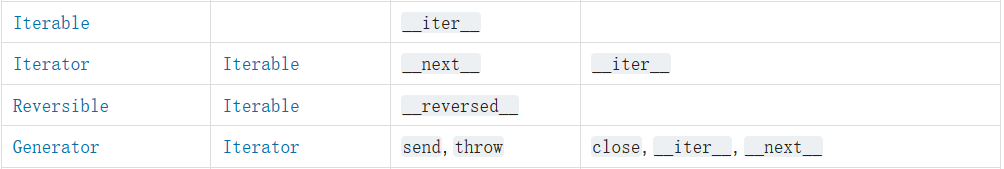

### 生成器的`throw`和`close`方法

生成器有`throw`和`close`方法，平时用的不多，但是理解它们可以更深刻的理解生成器，主要要注意两点：
- `generator.throw(exc_type[, exc_value[, traceback]])`：致使生成器在暂停的`yield`表达式处抛出指定的异常。如果生成器处理了抛出的异常，代码会向前执行到下一个`yield`表达式，而产出的值会成为调用`generator.throw`方法得到的返回值。如果生成器没有处理抛出的异常，异常会向上冒泡，传到调用方的上下文中。
- `generator.close()`：致使生成器在暂停的`yield`表达式处抛出`GeneratorExit`异常。如果生成器没有处理这个异常，或者抛出了`StopIteration`异常（通常是指运行到结尾），调用方不会报错。如果收到`GeneratorExit`异常，生成器一定不能产出值，否则解释器会抛出`RuntimeError`异常。生成器抛出的其他异常会向上冒泡，传给调用方。

### 深入理解`yield from` 

在介绍`yield from`之前，先稍微回顾一下普通的生成器（协程）的处理机制，如下的生成器：

In [4]:
def c():
    yield 1
    yield 2
    return 42

g = c()
print(next(g)) # 激活生成器
print(next(g))
try:
    next(g)
except StopIteration as e:
    print(e.value)

1
2
42


可见，依次通过`yield`返回1, 2，最后的返回值通过`StopIteration`异常的`value`属性返回，如果通过`for`语法对生成器进行迭代，当捕捉到`StopIteration`异常就会结束，不会处理带出来的返回值：

In [5]:
for i in c():
    print(i)

1
2


再来看`yield from`语句，任何包含`yield from`语句的函数也是一个生成器，`yield from`后面跟着一个生成器或者可迭代对象，我们把包含`yield from`语句的生成器称为外层生成器（官方称呼为委派生成器），`yield from`语句后面跟着的生成器称为内层生成器（也叫子生成器）。当它执行到`yield from`语句的时候，就会暂停挂起，去调用`yield from`后面的内层生成器，此时它就好像是透明的，调用者就像是直接在调用内层生成器一样，不过当内层生成器执行完毕，抛出`StopIteration`异常的时候，此时回到外层生成器，`yield from`此时会捕捉这个`StopIteration`异常，并提取它的`value`属性的值作为返回值。

In [8]:
def t():
    a = yield from c() # 此时t被挂起，执行c，当c执行完毕，捕捉c抛出的StopIteration实例，并将value属性的值赋给a
    yield a # 返回t，依次向下执行，这里将a返回

for i in t():
    print(i)

1
2
42


总的来说，`yield from`对里层生成器基本是透明的，调用外层生成器就像是在调用里层生成器一样，只不过是对里层生成器最后的返回值做了一点处理。当然实际上，它还做了一些其它的事情，比如对`yield from`后面跟着的可迭代对象使用`iter()`方法转化成迭代器，激活生成器等等。但是以上是理解`yield from`的关键。

## 描述符

### 什么时候用描述符？和特性使用场景的差异

当很多属性有相同的逻辑的时候，此时用描述符比用特性`@property`好--因为此时用特性的话，每个特性都要编写相同的逻辑。比如这样的一个场景，定义一个学生类，各科成绩是其特性，成绩必须要在0-100分之间，如果用特性来写的话，只能这样：

In [26]:
class Student:
    @property
    def math(self):
        return self.mscore
    
    @math.setter
    def math(self, score):
        if not (0 <= score <= 100):
            raise ValueError("分数不能大于100小于0!")
        self.mscore = score
        
    @property
    def english(self):
        return self.escore
    
    @english.setter
    def english(self, score):
        if not (0 <= score <= 100):
            raise ValueError("分数不能大于100小于0!")
        self.mscore = score        

可见，特性有相同的验证逻辑，因此每个特性里面都要写相同的验证代码，此时可以用描述符来代替：

In [6]:
class Score:
    def __get__(self, inst, cls):
        if inst is None:
            return self
        return self.score
    
    def __set__(self, inst, value):
        if not (0 <= value <= 100):
            raise ValueError("分数不能大于100小于0!")
        self.score = value


class Student:
    math = Score()
    english = Score()

In [7]:
s1 = Student()
s1.math = 75
s1.math

75

使用描述符的话，就不用重复写相同的代码。但是可惜，上面的代码仍然有问题，如下，`s2`实例的`math`设置为89，此时`s1`实例的`math`属性也成了89：

In [33]:
s2 = Student()
s2.math = 89
s2.math
s1.math

89

89

这是因为描述符是类属性，在类定义的时候就会执行`math = Score()`代码，所以`Student`的`math`属性其实都引用的是同一个描述符实例，可以这样解决：

In [47]:
class Score:
    def __init__(self):
        self.score = {}
    
    def __get__(self, inst, cls):
        if inst is None:
            return self
        return self.score[inst]
    
    def __set__(self, inst, value):
        if not (0 <= value <= 100):
            raise ValueError("分数不能大于100小于0!")
        self.score[inst] = value


class Student:
    math = Score()
    english = Score()

In [48]:
s1 = Student()
s1.math = 75
s1.math
Student.math.score

75

{<__main__.Student at 0x17e26aa5e08>: 75}

上面的解决方案仍然有最后一个小问题，就是会引起内存泄漏，因为描述符的`score`字典引用了`s1`,`s2`这样的实例，导致`s1`,`s2`实例不会被垃圾回收（反复运行上面一行的代码，可以发现每一次都新建了一个`Student`的实例，`Student.math.score`字典里的实例越来越多，无法回收）。因此最终的解决办法是将字典改为弱引用的：
```python
score = WeakKeyDictionary()
```

还有一种方法，即实际的属性不保存在描述符的实例里，而是保存在`Student`的实例中，如下：

In [67]:
class Score:
    def __init__(self, attrname):
        self.attrname = "_" + attrname
    
    def __get__(self, inst, cls):
        if inst is None:
            return self
        return getattr(inst, self.attrname)
    
    def __set__(self, inst, value):
        if not (0 <= value <= 100):
            raise ValueError("分数不能大于100小于0!")
        setattr(inst, self.attrname, value)


class Student:
    math = Score("math")
    english = Score("english")

上面这种应该是最简单的了，但是还有个小遗憾就是每次定义描述符，都要传入一个和属性名相同的字符串，显得有点冗余，可以用元类解决：

In [65]:
class Meta(type):
    def __new__(meta, clsname, bases, clsdict):
        for key, value in clsdict.items():
            if isinstance(value, Score):
                value.attrname = "_" + key
        return type.__new__(meta, clsname, bases, clsdict)


class Score:
    def __get__(self, inst, cls):
        if inst is None:
            return self
        return getattr(inst, self.attrname, 0)

    def __set__(self, inst, value):
        if not (0 <= value <= 100):
            raise ValueError("分数不能大于100小于0!")
        setattr(inst, self.attrname, value)


class Student(metaclass=Meta):
    math = Score()
    english = Score

In [66]:
s1 = Student()
s2 = Student()
s1.math = 75
s1.math
s2.math = 89
s2.math
Student.math.__dict__

75

89

{'attrname': '_math'}

### 描述符的几个主要应用场景

#### 使用仅有`__set__`方法的描述符进行验证

当要对类的属性进行验证，此时可以使用只包含`__set__`方法的描述符，`__set__ `方法应该检查`value`参数获得的值，如果有效，使用描述符实例的名称为键， 直接在实例的`__dict__ `属性中设置。读取的时候则不需要经过`__get__`的处理：

In [81]:
class D:
    def __set__(self, inst, value):
        if isinstance(value, str):
            print("I am StrData descriptor")
            inst.__dict__["data"] = value
        else:
            raise TypeError("data属性要是字符串")


class C:
    data = D()


c = C()
c.data = "foo"
c.data
try:
    c.data = 123
except Exception as e:
    print(e)

I am StrData descriptor


'foo'

data属性要是字符串


注意，设置实例属性一定要用`inst.__dict__["data"] = value`的形式，不能直接`inst.data = value`，因为`inst.data`又会触发`__set__`方法，从而陷入无限循环。

#### 使用仅有`__get__`方法的描述符进行数据的高速缓存

当某一个属性需要进行复杂的计算，可以使用仅有`__get__`方法的描述符，在第一次读取属性的时候进行计算，然后将结果保存为实例的与描述符同名的属性，后期就会直接读取实例属性，不会再触发`__get__`方法，从而实现了数据的告诉缓存：

In [82]:
class D:
    def __get__(self, inst, owner):
        if inst is None:
            return self  # 如果从类访问描述符，则返回描述符本身
        else:
            print("computing....")
            inst.data = 42  # 42代表计算出的结果
            return 42


class C:
    data = D()


c = C()
c.data  # 第一次读取data属性，此时c.data是描述符，触发__get__方法，进行计算，返回结果，并保存为实例的同名属性
c.data  # 第二次读取data属性，此时c.data是实例属性，不会再触发__get__方法，从而实现了数据的高速缓存

computing....


42

42

上述的场景都是利用了描述符`__set__`和`__get__`方法的不对称性，`__set__`方法是覆盖型方法，它会覆盖实例的同名属性，意思是写入属性的时候，即使实例有和描述符相同名字的属性，它也会进行拦截。而`__get__`方法是非覆盖的，如果实例有和描述符相同名称的属性，则读取的时候，不会再触发`__get__`方法，直接读取实例的属性。

### 使用描述符做方法的装饰器

我们可以用函数，和类作装饰器，但是，在装饰方法的时候，类作为装饰器就不好用了，如下：

In [82]:
class Wrapper:
    def __init__(self, func):
        self.func = func

    def __call__(self, *args, **kwargs):
        print("in wrapper")
        return self.func(*args, **kwargs)


@Wrapper
def func(a, b):
    return a + b


func(2, 3)

in wrapper


5

使用`Wrapper`类包装方法时，会报错，因为此时`c.func`返回的是`Wrapper`的实例，然后再调用`Wrapper`实例的`__call__`方法，这个过程丢失了`C`的`self`实例的传递：

In [86]:
class C:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    @Wrapper
    def func(self):
        return self.a + self.b


c = C(2, 3)
try:
    c.func()
except TypeError as e:
    print(e)

in wrapper
func() missing 1 required positional argument: 'self'


此时给`C`类添加`__get__`方法，将其变为一个描述符：

In [93]:
class Wrapper:
    def __init__(self, func):
        self.func = func
        
    def __get__(self, inst, cls):
        def wrapper(*args, **kwargs):           
            print("in wrapper")
            return self.func(inst, *args, **kwargs)
        return wrapper


class C:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    @Wrapper
    def func(self):
        return self.a + self.b

c = C(2, 3)
c.func()

in wrapper


5

也可以使用一个包含`__get__`和`__call__`方法的类作为装饰器：

In [94]:
class Wrapper:
    def __init__(self, func):
        self.func = func
        
    def __call__(self, *args, **kwargs):
        print("in wrapper")
        return self.func(self.inst, *args, **kwargs)
        
    def __get__(self, inst, cls):
        self.inst = inst
        return self


class C:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    @Wrapper
    def func(self):
        return self.a + self.b

c = C(2, 3)
c.func()

in wrapper


5

## 元类

### `__call__`，`__new__`，`__init__`的执行顺序

先执行元类的元类的`__call__`方法，该方法依次调用元类的`__new__`方法和`__init__`方法：

In [283]:
class MMCls(type):
    def __call__(metacls, clsname, base, attrs):
        print("MMCls __call__ invoked:")
        print(metacls, clsname, base, attrs)
        return super().__call__(clsname, base, attrs)


class MCls(type, metaclass=MMCls):
    def __new__(metacls, clsname, base, attrs):
        print("MCls __new__ invoked:")
        print(metacls, clsname, base, attrs)
        return super().__new__(metacls, clsname, base, attrs)

    def __init__(cls, clsname, base, attrs):
        print("MCls __init__ invoked:")
        print(cls, clsname, base, attrs)
        super().__init__(clsname)


class Cls(metaclass=MCls):
    pass

MMCls __call__ invoked:
<class '__main__.MCls'> Cls () {'__module__': '__main__', '__qualname__': 'Cls'}
MCls __new__ invoked:
<class '__main__.MCls'> Cls () {'__module__': '__main__', '__qualname__': 'Cls'}
MCls __init__ invoked:
<class '__main__.Cls'> Cls () {'__module__': '__main__', '__qualname__': 'Cls'}


### 元类和普通类的`__new__`方法的区别

### 元类中`__new__`和`__init__`方法的区别

简单来说，`__new__`在创建类之前运行，`__init__`在创建类之后运行，`__init__`可以做的，`__new__`都可以做，反之则不然。对于`__new__`来说，四个参数：`metacls, clsname, supercls, attrsdict`缺一不可，但是对`__init__`来说，只需要`cls, clsname`两个参数就够了。 接下来通过两个主要的场景来理解它们之间的区别。
- 场景一：通过元类编程的方式让一个类继承另一个类  
此时这种情况就只能使用`__new__`,因为使用`__init__`的时候，类已经创建了，无法再修改它的父类。

In [26]:
class MetaCls(type):
    def __new__(meta, name, bases, attrs):  
        bases = bases + (C, )
        return type.__new__(meta, name, bases, attrs)
    
    def __init__(cls, name, bases, attrs):
        type.__init__(cls, name)


class C:
    a = "I am C's attribute!"

class D(metaclass=MetaCls):
    pass

In [29]:
D.__mro__

(__main__.D, __main__.C, object)

- 场景二：给类添加新的属性  
这种场景两个方法都可以，但是写法不同：

In [31]:
class MetaCls(type):
    def __new__(meta, name, bases, attrs):  
        attrs['a'] = 'I am in metacls __new__'
        return type.__new__(meta, name, bases, attrs)

class C(metaclass=MetaCls):
    pass

In [32]:
C.a

'I am in metacls'

在`__new__`中，由于类还没有创建，所以只能通过修改`attrs`的方式给类添加属性。

In [33]:
class MetaCls(type):
    def __init__(cls, name, bases, attrs):  
        # attrs['a'] = 'I am in metacls' 不能通过此种方式，此时类已经创建，attrs只是保存类属性的一个字典，修改它并不会改变类的属性
        cls.a = 'I a in metacls __init__'
        return type.__init__(cls, name)

class C(metaclass=MetaCls):
    pass

In [34]:
C.a

'I a in metacls __init__'

注意，在`__init__`中，类已经创建，不能通过直接修改`attrs`字典的方式来改变类的属性（你会发现根本不起作用），只能通过`cls.attr`的方式来修改。

### 动态添加类属性

动态将函数添加为类的静态属性：

In [36]:
def a():
    return 'a'

def b():
    return 'b'

In [37]:
class Meta(type):
    def __new__(metacls, clsname, bases, attrs):
        for func in [a, b]:
            attrs[func.__name__] = staticmethod(func)
        return type.__new__(metacls, clsname, bases, attrs)

class C(metaclass=Meta):
    pass

动态将函数添加为类的普通属性：

In [38]:
from functools import partial

class Meta(type):
    def __new__(metacls, clsname, bases, attrs):
        for func in [a, b]:
            # 注意两点：
            # 1.因为要多传递一个self参数，所以通过回调函数传参
            # 2.回调函数必须使用func=func的方式将func赋值给本地，否则关联的永远是最后一个func
            def wrapper(func=func, *args, **kwargs): 
                return func(*args[1:], **kwargs)            
            attrs[func.__name__] = partial(wrapper, func)
        return type.__new__(metacls, clsname, bases, attrs)

class D(metaclass=Meta):
    pass

## 多线程和多进程

### 多线程

[《聊聊Python中的GIL》](https://www.cnblogs.com/ArsenalfanInECNU/p/9968621.html)  
[《Python中的多线程编程，线程安全与锁（一）》](https://www.cnblogs.com/ArsenalfanInECNU/p/10022740.html)  
[《Python中的多线程编程，线程安全与锁（二）》](https://www.cnblogs.com/ArsenalfanInECNU/p/10134591.html)  
[《线程间同步之条件变量Condition》](https://www.jianshu.com/p/5d2579938517)

#### `join`，`setDameon`的区别

- 默认情况下，主线程会等所有的子线程执行完毕以后再退出。
- `join`是指主线程阻塞，等子线程执行完毕以后再往下执行，可以理解成子线程“加入”主线程，所以必须在子线程运行起来（`start()`）以后再`join`，注意，主程序在线程`join()`调用处阻塞。

In [9]:
import threading
from time import sleep


def func():
    print("子线程开始运行。")
    sleep(4)
    print("子程序结束运行。")

class MyThread(threading.Thread):       
    def join(self):
        print("子线程加入主线程，主线程阻塞，等待子线程结束。")
        super().join()

        
t = MyThread(target=func)
t.start()
sleep(2)
print("现在仍然在主线程里面。")
t.join()
print("主线程结束。")

子线程开始运行。
现在仍然在主线程里面。
子线程加入主线程，主线程阻塞，等待子线程结束。
子程序结束运行。
主线程结束。


- `setDaemon`值将子进程设置为后台进程（一般都是翻译成守护进程，我觉得这个翻译反而会让人误解），设置为后台进程以后，主线程就不会再阻塞着等待子线程了，会直接向下执行，主进程结束的时候，子进程也跟着结束。注意，`subthread.setDaemon(True)`需要在子进程`start()`运行起来之前，先声明它是后台进程。或者在定义子进程的时候，通过`daemon`参数设置。

```python
import threading
from time import sleep

def func1():
    print('func1 start')
    sleep(2)
    print('func1 end')
    
def func2():
    print('func2 start')
    sleep(4)
    print('func2 end')

t1 = threading.Thread(target=func1)
t2 = threading.Thread(target=func2, daemon=True)
t1.start()
t2.start()
```
以上代码，不会出现`func2 end`，但是在`jupyter`的交互式环境中，还是会打印的。

#### `concurrent.futures`的细节

使用多线程和多进程最简单的方法，就是使用内部库的`concurrent.futures`模块，它是对内部的`threading`和`multiprocessing`库的上层封装，分别对应`futures.ThreadPoolExecutor()`和`Futures.ProcessPoolExecutor()`两个方法。两种方法都返回一个`Executor`执行器，使用的时候，主要有两种方式，一种是使用`executor`的`map`方法，一种是使用`executor`的`submit`搭配`as_completed`方法。
1. `map`方法如下几点主要注意：
    - `map`方法直接返回一个结果的生成器，生成器内部实际上是一个期程（`Future`）的列表，迭代生成器时，实际上依次调用期程（`Future`）的`result()`的方法。如果线程还没有执行完，会在这里阻塞，等待`result()`返回结果，如果发生异常，也会在这里抛出，同时结束，返回主线程。因此最后的结果和传入参数顺序是一样的。

In [2]:
from concurrent import futures
from time import sleep
from datetime import datetime

In [3]:
def now():
    now = datetime.now()
    return now.strftime("%Y-%m-%d %H:%M:%S")

In [4]:
def func1():
    print(f"func1 start, time is {now()}")
    sleep(4)
    return f"func1 end, time is {now()}"

def func2():
    print(f"func2 start, time is {now()}")
    sleep(2)
    return f"func2 end, time is {now()}"

def func3():
    print(f"func3 start, time is {now()}")
    sleep(3)
    raise TypeError("func3 error")
    
def func4():
    print(f"func4 start, time is {now()}")
    sleep(5)
    return f"func4 end, time is {now()}"

线程根本上还是时间排期，并非真正的并发，通过以下两个例子仔细体会每个时间点：

In [20]:
with futures.ThreadPoolExecutor(max_workers=3) as executor:
    # 立即对所有线程进行排期，开始并发执行，返回一个生成器，保留了加入时的顺序
    results = executor.map(lambda func:func(), [func1, func2, func3, func4]) 
    # 并发启动3个线程以后，回到主线程向下执行
    sleep(1)
    print(f"waiting...time is {now()}") 
    # 2秒钟后，func1线程结束，启动func4，然后又回到主线程向下执行
    try:
        # 这里隐式依次调用底层future的result()方法，如果线程还没有执行完，会在这里阻塞，异常也在这里抛出
        for r in results:  
            print(r)
    # 捕捉到func3抛出的错误，后面的线程会结束运行
    except TypeError as e: 
        print(e)

func1 start, time is 2019-12-05 10:16:57
func2 start, time is 2019-12-05 10:16:57
func3 start, time is 2019-12-05 10:16:57
waiting...time is 2019-12-05 10:16:58
func4 start, time is 2019-12-05 10:16:59
func1 end, time is 2019-12-05 10:17:01
func2 end, time is 2019-12-05 10:16:59
func3 error


In [22]:
with futures.ThreadPoolExecutor(max_workers=3) as executor:
    results = executor.map(lambda func:func(), [func1, func2, func3, func4]) 
    sleep(1)
    print(f"waiting...time is {now()}")
# 就算不调用期程的result方法，也会在with代码块的最后等待所有线程执行完毕
print(f"out with block, time is {now()}")

func1 start, time is 2019-12-05 10:19:44
func2 start, time is 2019-12-05 10:19:44
func3 start, time is 2019-12-05 10:19:44
waiting...time is 2019-12-05 10:19:45
func4 start, time is 2019-12-05 10:19:46
out with block, time is 2019-12-05 10:19:51


可见，4个函数同时运行，然后按照传入的顺序依次返回结果，当遇到异常时，整个退出，未获得`func4`的结果。

2. `submit`方法一般都是和`as_completed`方法搭配使用，注意以下几点：
    - `submit`明确的返回一个期程。然后调用`as_completed`方法，将多个期程组成的列表传入`as_completed`方法，返回一个期程的生成器。
    - 和`map`不同，生成器会按照执行完成的先后顺序返回执行完毕的期程，注意在隐性调用`next`的时候阻塞，而不是`future.result()`的时候。
    - 注意异常在调用`future.result()`的时候抛出，因此可以捕获单个`future`的异常，获取全部`future`的结果。

In [24]:
with futures.ThreadPoolExecutor(max_workers=3) as executor:
    future1 = executor.submit(func1)  # 返回一个已排期的期程，在这里会立即执行
    future2 = executor.submit(func2)
    future3 = executor.submit(func3)
    sleep(1)  # 同样的，启动以后立即回到主线程向下执行
    print(f"waiting...time is {now()}")
    # 返回func4的期程，但是这里不会马上执行，因为线程池是满的
    future4 = executor.submit(func4)
    # 这里并不会阻塞，只是返回一个期程构成的生成器
    done_iter = futures.as_completed([future1, future2, future3, future4])
    print(f"after as_completed...time is {now()}")
    # 此时func2执行完，线程池空了一个，开始启动func4的线程,然后马上又回到主线程
    try:
        # 一个线程结束才会进入生成器并返回，如果线程没有执行完就阻塞等待，所以哪个先执行完哪个先返回，不会保留顺序
        for f in done_iter: 
            print(f"waiting...time is {now()}")
            # 这里不会阻塞，因为此时的future是已经执行完毕的future，注意：如果有异常，会在这里抛出。
            print(f.result())
    # 如果在for循环外层捕获错误，则会和map一样，直接结束
    except TypeError as e:
        print(e)

func1 start, time is 2019-12-05 10:34:49
func2 start, time is 2019-12-05 10:34:49
func3 start, time is 2019-12-05 10:34:49
waiting...time is 2019-12-05 10:34:50
after as_completed...time is 2019-12-05 10:34:50
func4 start, time is 2019-12-05 10:34:51waiting...time is 2019-12-05 10:34:51

func2 end, time is 2019-12-05 10:34:51
waiting...time is 2019-12-05 10:34:52
func3 error


In [71]:
with futures.ThreadPoolExecutor(max_workers=3) as executor:
    future1 = executor.submit(func1)
    future2 = executor.submit(func2)
    future3 = executor.submit(func3)
    future4 = executor.submit(func4)
    done_iter = futures.as_completed([future1, future2, future3, future4])
    for f in done_iter:
         # 如果在内层捕捉异常，可以继续完成整个循环。
        try:
            print(f.result())
        except TypeError as e:
            print(e)

func1 start, time is 2019-11-12 13:12:46
func2 start, time is 2019-11-12 13:12:46
func3 start, time is 2019-11-12 13:12:46
func4 start, time is 2019-11-12 13:12:48
func2 end, time is 2019-11-12 13:12:48
func3 error
func1 end, time is 2019-11-12 13:12:50
func4 end, time is 2019-11-12 13:12:53


注意捕获异常的代码的位置，如果在`for`循环外层捕获异常，则会中断`for`循环，而在内层捕获，则可以继续完成整个循环。

3. 期程的其它方法：
    - `done()`：查看期程是否执行完毕。
    - `add_done_callback()`：给期程添加一个回调函数。注意：这个回调函数只接受一个参数就是期程。
    - `exception()`：和`result()`类似，阻塞主线程，如果有异常则返回，如果运行正常则返回None。

In [131]:
from functools import partial


def t():
    print(f"t started, time is {now()}")
    sleep(1)
    return 42


def cbfunc(f, func):
    if f.done():
        print(f"{func.__name__} end, time is {now()}")


with futures.ThreadPoolExecutor(max_workers=3) as executor:
    f = executor.submit(t)
    f.add_done_callback(partial(cbfunc, func=t))
    f.result()

t started, time is 2019-11-12 15:15:08
t end, time is 2019-11-12 15:15:09


42

3. 不设置`max_workers`的时候，就是不做限制，对于线程来说，传进去多少个就执行多少个。而对于进程来说，同时并发数和cpu的核个数有关。

#### 用`Queue`协调线程间的工作

使用`ThreadPoolExcutor`是很容易获取线程返回的结果的，但是当我们的工作分为好几个步骤，合适的做法是通过`Queue`来创建管道，先来看官方的生产者消费者模型的例子：
```python
def worker():
    while True:
        item = q.get()
        if item is None:
            break
        do_work(item)
        q.task_done()

q = queue.Queue()
threads = []
for i in range(num_worker_threads):
    t = threading.Thread(target=worker)
    t.start()
    threads.append(t)

for item in source():
    q.put(item)

# block until all tasks are done
q.join()

# stop workers
for i in range(num_worker_threads):
    q.put(None)
for t in threads:
    t.join()
```

注意，`join`和`task_done`的意义，`queue`内部维护着一个计数器，当向它`put`一个元素的时候，计数器加1，当在`queue`上调用`task_done()`的时候，计数器减一，当调用`q.join()`的时候，会在这里阻塞，一直等到计数器为0。

以下的自定义类对`queue`进行了扩展，可以对其进行迭代，可以直接在`Queue`上进行关闭：

In [15]:
from queue import Queue


class MyQueue(Queue):
    SIG = object()

    def close(self, n_workers=1):
        for i in range(n_workers):
            self.put(self.SIG)

    def __iter__(self):
        while True:
            item = self.get()
            try:
                if item is self.SIG:
                    return
                yield item
            finally:
                self.task_done()

注意，上面这个类在使用的时候，需要先调用`close`，然后再在`queue`上调用`join`,官方的例子可以改成下面这样：

In [16]:
import threading
from time import sleep


def worker(n):
    for item in q:
        print(f"worker {item} start!")
        sleep(n)
        print(f"worker {item} finished!")
        
q = MyQueue()

ts = []

for i in [1, 2]:
    t = threading.Thread(target=worker, args=(i, ))
    t.start()
    ts.append(t)
    
for i in ["thread1", "thread2", "thread3", "thread4"]:
    q.put(i)
    
q.close(n_workers=len(ts))
q.join()

worker thread1 start!
worker thread2 start!
worker thread1 finished!
worker thread3 start!
worker thread2 finished!
worker thread4 start!
worker thread3 finished!
worker thread4 finished!


### 多进程

#### 使用`subprocess`管理子进程

所谓子进程就是指另起一个进程执行系统内的其它程序，网上搜索的话，可能会搜出各种方案，比如使用`os.system`，`win32process`模块等等，但是对新版本的python来说，最好的方法就是使用`subprocess`模块。

但是`subprocess`模块中有几个概念不太好理解，这里记录个人遇到的一些问题：

推荐使用`subprocess.run()`作为执行外部程序的入口，这个函数是对底层`subprocess.Popen()`接口的上层封装。`subprocess.run()`的函数签名如下：
```python
subprocess.run(args, *, stdin=None, input=None, stdout=None, stderr=None, capture_output=False, shell=False, cwd=None, timeout=None, check=False, encoding=None, errors=None, text=None, env=None, universal_newlines=None)
```
`args`参数：是要执行的命令，可以为一个字符串，或者一个程序参数序列。提供一个参数序列通常更好，它可以更小心地使用参数中的转义字符以及引用（例如允许文件名中的空格）。如果传递一个简单的字符串，则 `shell` 参数必须为 `True` 或者该字符串中只有被运行的程序名而不指定任何参数。不过windows中，序列会按照一定规则转换成字符串，因为底层的`CreateProcess()`只处理字符串。

`shell`参数：是指使用系统内置的`shell`来执行外部程序，对于windows来说，有些命令是内置在`shell`中的，比如`dir`,`copy`，因此执行这些命令，必须设置`shell=True`。

#### 使用`Futures.ProcessPoolExecutor()`实现并行计算

## 协程

[官方入门文档](https://docs.python.org/zh-cn/3.8/library/asyncio-task.html#coroutine)  
[Python Async/Await入门指南](https://zhuanlan.zhihu.com/p/27258289)  
[一份详细的asyncio入门教程](https://zhuanlan.zhihu.com/p/59671241)

协程比较难理解的，《流畅的python》第16章对协程的底层原理讲解的比较透彻。《一份详细的asyncio入门教程》对如何使用协程有较为全面的介绍，这里记载一些遇到的问题以及不同的场景如何使用协程。

### 3种可等待对象

- 协程：注意，协程本身是个函数，调用它以后才返回一个协程。协程是最基础的可等待对象，可以在其它的协程中被等待。无法排期，所谓无法排期，个人理解就是不能加入后台的优先级队列。
- 任务：对协程进行了包装，是期程的子类，可以排期，并发执行，主要就是执行任务，一旦`create_task`创建一个任务，主程序被挂起，立即执行这个任务，执行到`await`语句，返回的结果加入到后台的优先级队列，任务被挂起，然后返回主程序，一直到`await 任务`的语句，返回之前存入队列的结果，然后从任务的中断处继续执行任务。
- 期程：一种特殊的低层级可等待对象，表示一个异步操作的最终结果。一般不使用，只有库的作者需要编写`Future`。

### 执行协程的两种方式

1. 使用`asyncio.run()`+`asyncio.create_task`的方式，`asyncio.run()`是协程的高级api，它隐藏了底层的事件循环代码。要注意的是，它总是创建一个新的事件循环并且在结束的时候关闭它，如果在同一线程中已经有事件循环，则会报错。因此，如果在jupyter里面，使用`asyncio.run()`，总是会报错，因为jupyter是异步的，它本身运行着一个事件循环。基本的使用方法是先创建一个入口，在入口里面通过`create_task`创建任务：

```python
import asyncio
import time


async def c1():
    print(f"c1 started at {time.strftime('%X')}")
    await asyncio.sleep(2)
    print(f"c1 ended at {time.strftime('%X')}")
    return 42


async def c2():
    print(f"c2 started at {time.strftime('%X')}")
    await asyncio.sleep(3)
    print(f"c2 ended at {time.strftime('%X')}")
    return 24


async def main():
    t1 = asyncio.create_task(c1())
    t2 = asyncio.create_task(c2())
    r1 = await t1
    r2 = await t2
    return r1, r2


print(asyncio.run(main()))
```
最后输出结果为：
```
c1 started at 00:35:23
c2 started at 00:35:23
c1 ended at 00:35:25
c2 ended at 00:35:26
(42, 24)
```

2. 显示的创建事件循环，一般是`loop=asynic.get_event_loop()`+`loop.run_untill_completed()`的方式，在`jupyter`下，尝试下面的代码，注意，不能把`t.result()`放在同一个`cell`，因为`jupyter`的机制和默认不太一样，不会`create_task`的时候就立即执行任务，而是等`cell`里的代码执行完毕以后立即去执行任务。所以这里需要等待3秒，看到`c ended`出现以后，再调用`t.result()`才能获得结果，否则会抛出`InvalidStateError`错误。

In [9]:
import asyncio
import time


async def c():
    print(f"c started at {time.strftime('%X')}")
    await asyncio.sleep(3)
    print(f"c ended at {time.strftime('%X')}")
    return 42


loop = asyncio.get_running_loop()
t = loop.create_task(c())

c started at 00:48:50
c ended at 00:48:53


In [10]:
t.result()

42

## 常用库

### 常用库查询手册

官方[内置的标准库](https://docs.python.org/zh-cn/3.8/library/index.html)的说明，以下是收集的关于各种库的解释比较好的文章：

- `time`和`datetime`：内置，时间和日期处理，参考[《python time模块和datetime模块详解》](https://www.cnblogs.com/tkqasn/p/6001134.html)
- `difflib`：内置，对比文本之间的差异。参考[《python difflib模块讲解示例》](https://blog.csdn.net/lockey23/article/details/77913855)
- `math`和`cmath`：内置，`math`模块包含浮点数的数学运算函数，`cmath`模块运算的是复数。参考[《python math和cmath模块介绍》](https://blog.csdn.net/hdutigerkin/article/details/6694884)
- `aiohttp`： 内置，异步的http请求库，参考[《python aiohttp简易使用教程》](https://blog.csdn.net/weixin_41004350/article/details/78780452)
- `click`：第三方库，命令行参数神器，[官方地址](https://click.palletsprojects.com/en/7.x/)，参考[《click--命令行神器》](https://www.jianshu.com/p/6a533a892167)
- `sqlite3`：内置，`sqlite`数据库处理，参考[《Python Sqlite教程》](https://blog.csdn.net/pansaky/article/details/99674449)

### 使用`fnmatch`，`glob`，`os.path`和`pathlib`匹配文件

文件目录操作常用的一共4个模块，分别是`fnmatch`，`glob`，`os.path`和`pathlib`，其中，`fnmatch`和`glob`主要用于文件名的匹配，`os.path`和`pathlib`主要用于目录操作，在3.6以后，使用面对对象的`pathlib`更好。

相关的文章：
- [Python模块学习 - fnmatch & glob](https://www.cnblogs.com/dachenzi/p/8215584.html)
- [超好用的pathlib](https://blog.csdn.net/weixin_42232219/article/details/91349908)
- [pathlib官方文档](https://docs.python.org/zh-cn/3/library/pathlib.html#pathlib.Path.replace)

`fnmatch`一般和`os.listdir`搭配来匹配文件名：

In [64]:
import fnmatch

[name for name in os.listdir("F:\\movie\\movie\\") if fnmatch.fnmatch(name, "*.mkv")]

['The.Equalizer.2014.伸冤人.双语字幕.HR-HDTV.AC3.1024X576.x264.mkv',
 '[教父 3.1990.国英双语.中英字幕].九洲客.mkv']

`glob`结合了`os.listdir`和`fnmatch`的功能，可以输入路径进行匹配，默认是在当前目录：

In [65]:
import glob

glob.glob("F:\\movie\\movie\\*.mkv")

['F:\\movie\\movie\\The.Equalizer.2014.伸冤人.双语字幕.HR-HDTV.AC3.1024X576.x264.mkv',
 'F:\\movie\\movie\\[教父 3.1990.国英双语.中英字幕].九洲客.mkv']

`pathlib`包含上述功能：

In [69]:
from pathlib import Path

list(Path("F:\\movie\\movie\\").glob("*.mkv"))

[WindowsPath('F:/movie/movie/The.Equalizer.2014.伸冤人.双语字幕.HR-HDTV.AC3.1024X576.x264.mkv'),
 WindowsPath('F:/movie/movie/[教父 3.1990.国英双语.中英字幕].九洲客.mkv')]

### `sqlite3`使用技巧

1. 以字典类型返回`select`的数据
默认情况下，`select`出来的`row`只能使用数字作为下标，可以以字典类型返回数据，在`cur = conn.cursor()`之前加入`con.row_factory = sqlite.Row`即可。
2. 以编程方式获取列名：有两种方式，一种是通过`PRAGMA`，`cur.execute("PRAGMA table_info(table_name)")`，返回每一列的元数据，是元组构成的列表，如下：
```python
[(0, 'ID', 'INTEGER', 0, None, 1), (1, 'CARDID', 'TEXT', 0, None, 0), (2, 'CHARGETIME', 'TEXT', 0, None, 0), (3, 'CHARGE', 'REAL', 0, None, 0), (4, 'REMAINING', 'REAL', 0, None, 0), (5, 'CHECKTIME', 'TEXT', 0, None, 0)]
```

一种是通过`cursor`的`description`属性，当执行`select`语句以后，`cursor`的`description`返回一个元组构成的元组，如下：
```python
(('ID', None, None, None, None, None, None), ('CARDID', None, None, None, None, None, None), ('CHARGETIME', None, None, None, None, None, None), ('CHARGE', None, None, None, None, None, None), ('REMAINING', None, None, None, None, None, None), ('CHECKTIME', None, None, None, None, None, None))
```
3. 使用`'\n'.join(conn.iterdump())`语句可以将数据库进行备份，原理上就是根据目前的数据生成相应的多个`sql`语句。相反的，可以使用`cur.executescript(sql)`导入。注意，这里的`sql`是多行字符串。
4. 默认支持回滚，可以设置为自动提交模式，`con = sqlite.connect('ydb.db', isolation_level=None)`。注意，不传入`isolation_level`或者设置为`isolation_level==''`，为智能提交模式，即在进行执行`Data Modification Language (DML)`操作，即`(INSERT/UPDATE/DELETE/REPLACE)`时, 会自动打开一个事务，在执行非DML，非query(非SELECT和上面提到的)语句时, 会隐式执行`commit`。具体有什么区别，查看下面的文章：
  - [python sqlite3 的事务控制](https://my.oschina.net/tinyhare/blog/719039?utm_source=debugrun&utm_medium=referral)

## 其它

### 相关阅读

- [conda的简单使用](http://lizhiqiang.me/conda/)